## Пояснительная записка

Решение тестового конкурсного задания на стажировку "СКБ Контур" 24.04.2023 г. Выполнил Таширев Денис.

### Постановка задачи

Для выполнения тестового задания требуется разработать модель, которая будет способна по паре `текст документа` и `пункт анкеты` извлекать из текста документа нужный фрагмент текста.

Обучив модель, добавить в файл `test.json` поле `extracted_part` в том же формате, что и в файле `train.json`. Новый файл назовите `predictions.json`.

Данные для обучения в формате json имеют следующие поля:
- `id`: int - id документа
-  `text`: str - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: str - название пункта анкеты. Может принимать одно из двух значений: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`
- `extracted_part`: dict следующего формата:
    ```
    {
        'text': [фрагмент текста из поля `text`, соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
   ```

1. Для оценки финального решения будет использоваться метрика `Accuracy`: доля наблюдений, в которых извлеченный моделью фрагмент текста полностью соответствует фактически
   требуемому фрагменту.
2. Чистота кода, оформление и понятность исследования.

Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

### Основные принятые решения

**В итоговом решении применялись следующие основные технологиях:**

    1) частотный анализ текста (библиотеки: pandas, seaborn)
    2) регулярные выражения (библиотека re), 
    3) лемматизация текста (библиотеки: pymorphy2, nltk),
    4) эмбеддинги текста (модель: DeepPavlov/rubert-base-cased),
    5) модель бустинга регрессия и классификация (библиотека catboost).

**Алгоритм модели предсказания:**

    1) лемматизация текста,
    2) получение признака длины текста,
    3) разделение данных по полю label (будут применены разные подходы),
    4) выделение текстов с отсутствующими фрагментами по длинне текста и
       ключевым словам из label (на этапе анализа выявлена очень сильная зависимость),
    5) предсказание регулярных фрагментов (частотность регулярных фрагментов определена на анализе,
       количество используемых фрагментов определено в ходе экспериментального подбора по качеству
       на валидационной выборке),
    6) для оставшихся текстов предсказываются приблизительные границы фрагментов в тексте:
        - 4 модели CatBoostRegressor (start и end для обоих label),
        - признаки: длинна текста и положение ключевых слов в тексте (слова отбирались по частотному
          анализу, как специфичные для фрагмента по отношению к основному тексту, а также тюнились
          при проверке на валидации),
        - признаковое пространство уплотнялось макспуллингом с ядром 40 (размер подобран на валидации),
        - функция потерь RMSE, метрика качетва MAE,
    7) на основании примерных признаков start и end, а также частотных слов для границ фрагментов 
       полученных из анализа данных, сформированы списки из 9-ти предположительных фрагментов,
    8) выбор фрагмента для предсказания из списка отличается для разных label (способы определены на валидации):
        - для label 'обеспечение исполнения контракта' выбор производится моделью бинарной классификации
          CatBoostClassifier, для каждого фрагмента из списка определяется вероятность (predict_proba), 
          выбирается фрагмент с наибольшей вероятностью, признаками служат 'сырой' текст фрагмента
          и эмбеддинг на модели (DeepPavlov/rubert-base-cased),
        - для label 'обеспечение гарантийных обязательств' выбирается фрагмент ограниченный
          самыми частотными словами границ фрагмента,
    9) финальное предсказание является объединением предсказаний:
        - отсутствующие фрагменты,
        - регулярные фрагменты,
        - фрагменты из модели CatBoostClassifier для label 'обеспечение исполнения контракта',
        - фрагменты ограниченные частотными словами для label 'обеспечение гарантийных обязательств'.

**Выполнены работы:**

    1) предобработка данных,
    2) анализ данных,
    3) моделирование решения,
    4) предсказание на тестовых данных,
    5) создан класс модели с методом predict.


**Структура файлов:**

    Tashirev_Denis
    ├── solution
    │   ├── dataset
    │   │   ├ train.json
    │   │   └ test.json
    │   ├ kontur_test_tashirev.ipynb
    │   ├ kontur_test_model.py
    │   ├ models_catboost.pickle
    │   └ config_words.pickle
    └ predictions.json
    
    - predictions.json - результат предсказания модели на test,
    - kontur_test_tashirev.ipynb - основной файл с решением задачи,
    - kontur_test_model.py - файл с классом модели KonturTest (пример применения см. пункт 11),
    - models_catboost.pickle - файл с предобученными моделями catboost,
      необходим для инициализации модели KonturTest (!!! будет сформирован
      при полном выполнении файла kontur_test_tashirev.ipynb, отсутствует
      по причине ограничений на размер архива 5 Мб),
    - config_words.pickle - файл с наборами слов и регулярных выражений,
      необходим для инициализации модели KonturTest (!!! будет сформирован
      при полном выполнении файла kontur_test_tashirev.ipynb, отсутствует
      по причине ограничений на размер архива 5 Мб),
    - train.json, test.json - тренировочный и тестовый набор данных.

## Импорты библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import pickle

import re
import pymorphy2
import nltk
from nltk.corpus import stopwords
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split

RANDOM_SEED = 1111

In [2]:
import warnings
warnings.filterwarnings("ignore")

Установка отсутствующих модулей.

## Чтение данных

In [3]:
train = pd.read_json('dataset/train.json')
display(train.head(3))
display(train.info())

,id,text,label,extracted_part
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1799 non-null   int64 
 1   text            1799 non-null   object
 2   label           1799 non-null   object
 3   extracted_part  1799 non-null   object
dtypes: int64(1), object(3)
memory usage: 56.3+ KB


None

## Предобработка данных

### Преобразование extracted_part в 3 столбца

In [4]:
def extracted_part_to_element(row_dict, key):
    return row_dict[key][0]

In [5]:
train['extracted_part_text'] = train['extracted_part'].apply(extracted_part_to_element, key='text')
train['answer_start'] = train['extracted_part'].apply(extracted_part_to_element, key='answer_start')
train['answer_end'] = train['extracted_part'].apply(extracted_part_to_element, key='answer_end')

Проверка на корректность разбиения.

In [6]:
(
    train.loc[0,'extracted_part']['text'][0] == train.loc[0,'extracted_part_text'],
    train.loc[0,'extracted_part']['answer_start'][0] == train.loc[0,'answer_start'],
    train.loc[0,'extracted_part']['answer_end'][0] == train.loc[0,'answer_end'],
)

(True, True, True)

In [7]:
train.head(3)

,id,text,label,extracted_part,extracted_part_text,answer_start,answer_end
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 6593.2...,1279,1343
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...,Поставщик должен предоставить обеспечение испо...,1222,1318
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1297,1343


### Преобразование `label`

Проверка уникальности значений `label`

In [8]:
train['label'].value_counts()

обеспечение исполнения контракта        988
обеспечение гарантийных обязательств    811
Name: label, dtype: int64

Создадим словарь и произведём подмену.

In [9]:
label_dict = {'обеспечение исполнения контракта':0,
              'обеспечение гарантийных обязательств':1,
             }

def fn_label_dict(text):
    return label_dict[text]

train['label'] = train['label'].apply(fn_label_dict)

Проверка применения словаря по количеству уникальных значений.

In [10]:
train['label'].value_counts()

0    988
1    811
Name: label, dtype: int64

### Проверка разметки длинны `extracted_part_text`

In [11]:
correct_length = []
for _, row in train.iterrows():
    correct_length.append(len(row['extracted_part_text']) == row['answer_end'] - row['answer_start'])

In [12]:
sum(correct_length) == train.shape[0]

True

Длинна всех extracted_part_text размечена верно.

### Проверка разметки `answer_start`

In [13]:
correct_answer_start = []
for _, row in train.iterrows():
    correct_answer_start.append(row['text'].find(row['extracted_part_text']) == row['answer_start'])

In [14]:
sum(correct_answer_start) == train.shape[0]

True

Все answer_start размечена верно.

### Признак `text_without_extracted_part`
Текст без фрагмента.

In [15]:
dict_text = {'text_without_extracted_part':[]}

for _, row in train.iterrows():
    
    dict_text['text_without_extracted_part'].append(row['text'][:row['answer_start']] + row['text'][row['answer_end']:])
train = pd.concat([train, pd.DataFrame(dict_text)], axis=1)

### Лемматизация `text`, `extracted_part_text`

In [16]:
morph = pymorphy2.MorphAnalyzer()
stopwords_ru = set(stopwords.words('russian'))
stopwords_ru.add('')

In [17]:
# функция получает текст,
# возвращает список лемматизированных слов (без стоп-слов)

def lemmatize(text):
    
    # разбиение текста на слова
    #words = text.split()
    
    words_list =[]
    words = re.split(r'(%)',text)
    
    for part in words:
        words_list.extend(re.split(r'[)|(|:|.|-| |,]',part))
    lemmatize_word_list = list()
    
    for word in words_list:
        # приведение к нормальной форме
        normal_word = morph.parse(word)[0].normal_form
        # проверка на число
        try:
            normal_word = float(normal_word)
            normal_word = 'число значение'
        except:
            None
        
        # исключение стоп-слов
        if normal_word not in stopwords_ru:
            lemmatize_word_list.append(normal_word)
    
    if len(lemmatize_word_list) == 0:
        lemmatize_word_list.append('пустота')
        
    return lemmatize_word_list

In [18]:
%%time
train['words_lemmatize'] = train['text'].apply(lemmatize)
train['extracted_part_words_lemmatize'] = train['extracted_part_text'].apply(lemmatize)
train['words_without_extracted_part_lemmatize'] = train['text_without_extracted_part'].apply(lemmatize)

CPU times: total: 4min 14s
Wall time: 4min 14s


In [19]:
train.head(3)

,id,text,label,extracted_part,extracted_part_text,answer_start,answer_end,text_without_extracted_part,words_lemmatize,extracted_part_words_lemmatize,words_without_extracted_part_lemmatize
0,809436509,Извещение о проведении открытого конкурса в эл...,0,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 6593.2...,1279,1343,Извещение о проведении открытого конкурса в эл...,"[извещение, проведение, открытый, конкурс, эле...","[размер, обеспечение, исполнение, контракт, чи...","[извещение, проведение, открытый, конкурс, эле..."
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,0,{'text': ['Поставщик должен предоставить обесп...,Поставщик должен предоставить обеспечение испо...,1222,1318,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,"[требование, содержание, заявка, участник, зап...","[поставщик, должный, предоставить, обеспечение...","[требование, содержание, заявка, участник, зап..."
2,4382157,Извещение о проведении электронного аукциона д...,0,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1297,1343,Извещение о проведении электронного аукциона д...,"[извещение, проведение, электронный, аукцион, ...","[размер, обеспечение, исполнение, контракт, чи...","[извещение, проведение, электронный, аукцион, ..."


!!!! УБРАТЬ ПУНКТУАЦИЮ в лемматизации, вместо пустых списков выдать "пустота", числа заменить на слово "число значение".

### Создание признака `extracted_part_true`

Признак наличия (1) или отсутствия (0) фрагмента в тексте.

In [20]:
train['extracted_part_true'] = (train['extracted_part_text'] != '').astype(int)

### Создание признака `text_len`

Длина текста в символах.

In [21]:
train['text_len'] = train['text'].apply(len)

### Создание признака `extracted_part_len`

Длина фрагмента текста в символах.

In [22]:
train['extracted_part_len'] = train['answer_end'] - train['answer_start']

### Создание столбца `text_lower`, `extracted_part_text_lower`

In [23]:
train['text_lower'] = train['text'].apply( lambda text: text.lower())
train['extracted_part_text_lower'] = train['extracted_part_text'].apply( lambda text: text.lower())

### Разбиение `train` по `label`

In [24]:
train_0 = train.query('label == 0').reset_index(drop=True)
train_1 = train.query('label == 1').reset_index(drop=True)

### Итоговые таблицы

Полная таблица.

In [25]:
train.head(3)

,id,text,label,extracted_part,extracted_part_text,answer_start,answer_end,text_without_extracted_part,words_lemmatize,extracted_part_words_lemmatize,words_without_extracted_part_lemmatize,extracted_part_true,text_len,extracted_part_len,text_lower,extracted_part_text_lower
0,809436509,Извещение о проведении открытого конкурса в эл...,0,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 6593.2...,1279,1343,Извещение о проведении открытого конкурса в эл...,"[извещение, проведение, открытый, конкурс, эле...","[размер, обеспечение, исполнение, контракт, чи...","[извещение, проведение, открытый, конкурс, эле...",1,2594,64,извещение о проведении открытого конкурса в эл...,размер обеспечения исполнения контракта 6593.2...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,0,{'text': ['Поставщик должен предоставить обесп...,Поставщик должен предоставить обеспечение испо...,1222,1318,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,"[требование, содержание, заявка, участник, зап...","[поставщик, должный, предоставить, обеспечение...","[требование, содержание, заявка, участник, зап...",1,2420,96,требования к содержанию заявки участника запро...,поставщик должен предоставить обеспечение испо...
2,4382157,Извещение о проведении электронного аукциона д...,0,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1297,1343,Извещение о проведении электронного аукциона д...,"[извещение, проведение, электронный, аукцион, ...","[размер, обеспечение, исполнение, контракт, чи...","[извещение, проведение, электронный, аукцион, ...",1,2492,46,извещение о проведении электронного аукциона д...,размер обеспечения исполнения контракта 10.00%


Таблица для label=0

In [26]:
train_0.head(3)

,id,text,label,extracted_part,extracted_part_text,answer_start,answer_end,text_without_extracted_part,words_lemmatize,extracted_part_words_lemmatize,words_without_extracted_part_lemmatize,extracted_part_true,text_len,extracted_part_len,text_lower,extracted_part_text_lower
0,809436509,Извещение о проведении открытого конкурса в эл...,0,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 6593.2...,1279,1343,Извещение о проведении открытого конкурса в эл...,"[извещение, проведение, открытый, конкурс, эле...","[размер, обеспечение, исполнение, контракт, чи...","[извещение, проведение, открытый, конкурс, эле...",1,2594,64,извещение о проведении открытого конкурса в эл...,размер обеспечения исполнения контракта 6593.2...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,0,{'text': ['Поставщик должен предоставить обесп...,Поставщик должен предоставить обеспечение испо...,1222,1318,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,"[требование, содержание, заявка, участник, зап...","[поставщик, должный, предоставить, обеспечение...","[требование, содержание, заявка, участник, зап...",1,2420,96,требования к содержанию заявки участника запро...,поставщик должен предоставить обеспечение испо...
2,4382157,Извещение о проведении электронного аукциона д...,0,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1297,1343,Извещение о проведении электронного аукциона д...,"[извещение, проведение, электронный, аукцион, ...","[размер, обеспечение, исполнение, контракт, чи...","[извещение, проведение, электронный, аукцион, ...",1,2492,46,извещение о проведении электронного аукциона д...,размер обеспечения исполнения контракта 10.00%


Таблица для label=1

In [27]:
train_1.head(3)

,id,text,label,extracted_part,extracted_part_text,answer_start,answer_end,text_without_extracted_part,words_lemmatize,extracted_part_words_lemmatize,words_without_extracted_part_lemmatize,extracted_part_true,text_len,extracted_part_len,text_lower,extracted_part_text_lower
0,195864972,Извещение о проведении электронного аукциона д...,1,{'text': ['Размер обеспечения гарантийных обяз...,Размер обеспечения гарантийных обязательств 15...,1297,1365,Извещение о проведении электронного аукциона д...,"[извещение, проведение, электронный, аукцион, ...","[размер, обеспечение, гарантийный, обязательст...","[извещение, проведение, электронный, аукцион, ...",1,2645,68,извещение о проведении электронного аукциона д...,размер обеспечения гарантийных обязательств 15...
1,276451923,ПРОЕКТ КОНТРАКТА Контракт №______ на поставку ...,1,{'text': ['Размер обеспечения гарантийных обяз...,Размер обеспечения гарантийных обязательств 1%...,1285,1404,ПРОЕКТ КОНТРАКТА Контракт №______ на поставку ...,"[проект, контракт, контракт, №______, поставка...","[размер, обеспечение, гарантийный, обязательст...","[проект, контракт, контракт, №______, поставка...",1,2641,119,проект контракта контракт №______ на поставку ...,размер обеспечения гарантийных обязательств 1%...
2,535432861,Проект типового контракта № _____ на поставку ...,1,{'text': ['Обеспечение гарантийных обязательст...,Обеспечение гарантийных обязательств устанавли...,1255,1393,Проект типового контракта № _____ на поставку ...,"[проект, типовой, контракт, №, _____, поставка...","[обеспечение, гарантийный, обязательство, уста...","[проект, типовой, контракт, №, _____, поставка...",1,2543,138,проект типового контракта № _____ на поставку ...,обеспечение гарантийных обязательств устанавли...


## Анализ данных

### Длинна в словах extracted_part_text

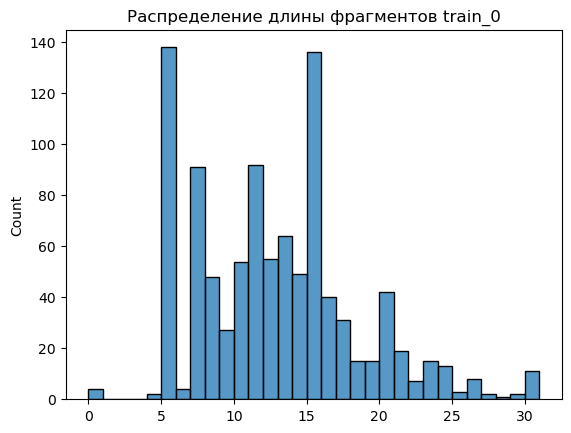

Наибольшая частота количества слов
5     138
15    136
11     92
7      91
13     64
dtype: int64


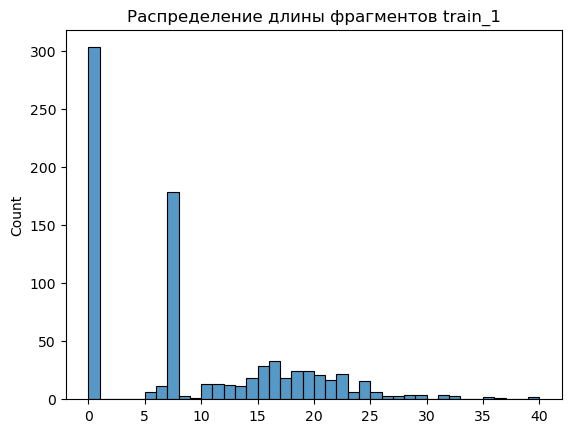

Наибольшая частота количества слов
0     303
7     178
16     33
15     29
19     24
dtype: int64


In [28]:
for name, df in (['train_0',train_0],['train_1', train_1]):
    df_len_list = []
    for text in df['extracted_part_text']:
        df_len_list.append(len(text.split()))
    series = pd.Series(df_len_list)
    sns.histplot(series, bins=series.max()).set(title='Распределение длины фрагментов '+name)
    plt.show()
    print('Наибольшая частота количества слов')
    print(series.value_counts()[:5])

Для `train_0` выбросы (отклонение от нормального распределения):

    - 5 - похоже на регулярный текст,
    - 15 - похоже на регулярный текст,
    - 11 - похоже на регулярный текст,
    - 7 - похоже на регулярный текст,
    - 8 - похоже на регулярный текст,
    - 20 - похоже на регулярный текст.

Для `train_1` выбросы:

    - 0 - это вероятно пустые фрагменты,
    - 7 - похоже на регулярный текст.

### Длинна в словах extracted_part_words_lemmatize

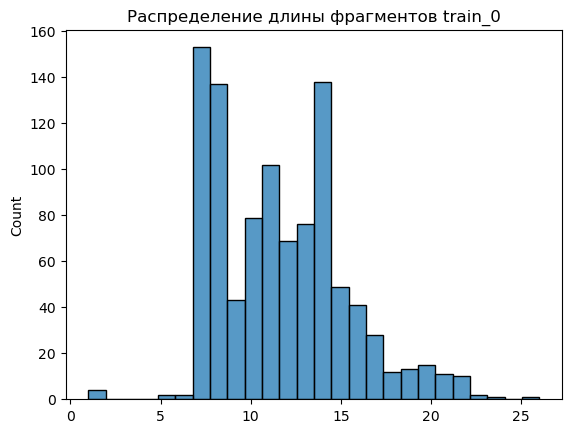

Наибольшая частота количества слов
7     153
14    138
8     137
11    102
10     79
dtype: int64


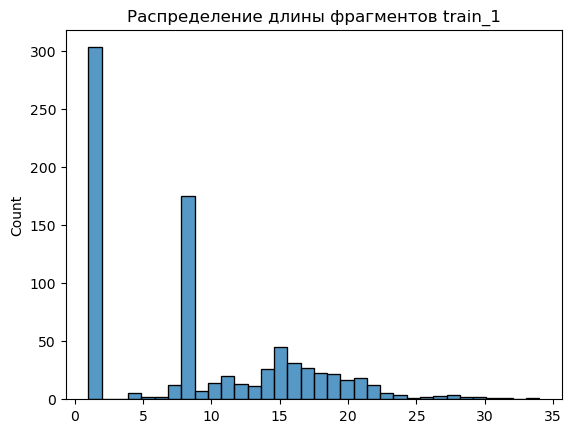

Наибольшая частота количества слов
1     303
8     175
15     45
16     31
17     27
dtype: int64


In [29]:
for name, df in (['train_0',train_0],['train_1', train_1]):
    df_len_list = []
    for words in df['extracted_part_words_lemmatize']:
        df_len_list.append(len(words))
    series = pd.Series(df_len_list)
    sns.histplot(series, bins=series.max()).set(title='Распределение длины фрагментов '+name)
    plt.show()
    print('Наибольшая частота количества слов')
    print(series.value_counts()[:5])

Для лемматизированного текста ситуация по распределению похожа (имеются некоторые смещения, по причине отличной разбивки и удаления стоп-слов).

### Регулярные фрагменты в `extracted_part_text`

In [30]:
# функция получает на вход series (столбец датафрейма с extracted_part_text),
# возвращает DataFrame с 20-ю наиболее частыми выражениями,
# для которых посчитана длина по словам и количество вхождений в series

def df_regular_part(series):
    df_regular = pd.DataFrame(series.value_counts()[:20]).reset_index()
    df_regular = df_regular.rename(columns = {'index':'extracted_part_text','extracted_part_text':'count'})
    df_regular['length'] = df_regular['extracted_part_text'].apply(lambda text: len(text.split()))
    return df_regular

#### `label` = 0

In [31]:
train_0_regular_part = df_regular_part(train_0['extracted_part_text'])
train_0_regular_part[:10]

,extracted_part_text,count,length
0,Размер обеспечение исполнения контракта устана...,86,15
1,Размер обеспечения исполнения контракта 5.00%,63,5
2,Размер обеспечения исполнения контракта 10.00%,47,5
3,Обеспечение исполнения настоящего Контракта ус...,35,8
4,не предусмотрено увеличенное от первоначально ...,17,20
5,Размер обеспечения исполнения договора составл...,9,11
6,Поставщик внес обеспечение исполнения Контракт...,8,20
7,не предусмотрено увеличенное от первоначально ...,8,23
8,Размер обеспечения исполнения контракта 30.00%,8,5
9,Размер обеспечения исполнения контракта 0.50%,7,5


Первые 5 строк, являются частыми регулярными текстами.

In [32]:
regular_parts_0 = train_0_regular_part.loc[:6,'extracted_part_text'].tolist()

#### `label` = 1

In [33]:
train_1_regular_part = df_regular_part(train_1['extracted_part_text'])
train_1_regular_part[:5]

,extracted_part_text,count,length
0,,303,0
1,Размер обеспечения гарантийных обязательств: 0...,7,6
2,Размер обеспечения гарантийных обязательств со...,6,16
3,Обеспечение гарантийных обязательств: Не устан...,5,5
4,Размер обеспечения исполнения гарантийных обяз...,5,21


Чётко выраженных регулярных текстов не наблюдается.

Выделяется большое число пустых фрагментов, что соответствует графику распределения.

In [34]:
regular_parts_1 = []

### Частотность слов

In [35]:
# принимает столбец датафрейма с лемматизированными списками,
# возвращает series (index -слово, значение - частота употребления)

def word_counts(series):
    
    words_list = []
    for words in series:
        words_list.extend(words)
    return pd.Series(words_list).value_counts()

#### Частотность слов в `extracted_part_words_lemmatize`

In [36]:
train_0_extracted_part_words_lemmatize_counts = word_counts(train_0['extracted_part_words_lemmatize'])
train_1_extracted_part_words_lemmatize_counts = word_counts(train_1['extracted_part_words_lemmatize'])

#### Частотность слов в `words_lemmatize`

In [37]:
train_0_words_lemmatize_counts = word_counts(train_0['words_lemmatize'])
train_1_words_lemmatize_counts = word_counts(train_1['words_lemmatize'])

### Частотность вхождения слов "исполнение", "контракт", "гарантийный", "обязательство", "пустота".

Слово "обеспечение" не учитывается, как принадлежащее обоим `label`.

In [38]:
train_0_extracted_part_words_lemmatize_counts[['исполнение','контракт','гарантийный','обязательство','пустота']]

исполнение       963
контракт         884
гарантийный        3
обязательство     18
пустота            4
dtype: int64

In [39]:
train_1_extracted_part_words_lemmatize_counts[['исполнение','контракт','гарантийный','обязательство','пустота']]

исполнение        87
контракт         212
гарантийный      536
обязательство    532
пустота          303
dtype: int64

In [40]:
train_0_words_lemmatize_counts[['исполнение','контракт','гарантийный','обязательство']]

исполнение       7344
контракт         7825
гарантийный       530
обязательство    1826
dtype: int64

In [41]:
train_1_words_lemmatize_counts[['исполнение','контракт','гарантийный','обязательство']]

исполнение       2139
контракт         3126
гарантийный      3233
обязательство    3134
dtype: int64

### Проверка вхождения ключевых слов в тексты.

In [42]:
# функция на входе получает series c лемматизированными списками и два ключевых слова,
# выводит на экран количество вхождений ключевых слов в лемматизированные списки

def words_in_text(series, word_1, word_2):
    
    word_1_counts = 0
    word_2_counts = 0
    all_words_counts = 0
    for words in series:
        word_1_counts += words.count(word_1)
        word_2_counts += words.count(word_2)
        all_words_counts += int(words.count(word_1)==0 and words.count(word_2)==0)
    print(f'Размер series - {series.shape[0]}')
    print(f'Число вхождений слова "{word_1}" - {word_1_counts}')
    print(f'Число вхождений слова "{word_2}" - {word_2_counts}')
    print(f'Число отсутствия "{word_1}" и "{word_2}" одновременно - {all_words_counts}')

#### Проверка на вхождение слов "исполнение", "контракт" для `train_0` с пустыми фрагментами

In [43]:
empty = ''
train_0_empty = train_0.query('extracted_part_text == @empty').reset_index(drop=True)

words_in_text(train_0_empty['words_lemmatize'], 'исполнение', 'контракт')

Размер series - 4
Число вхождений слова "исполнение" - 0
Число вхождений слова "контракт" - 0
Число отсутствия "исполнение" и "контракт" одновременно - 4


#### Проверка на вхождение слов "исполнение", "контракт" для `train_0` с НЕпустыми фрагментами

In [44]:
empty = ''
train_0_empty = train_0.query('extracted_part_text != @empty').reset_index(drop=True)

words_in_text(train_0_empty['words_lemmatize'], 'исполнение', 'контракт')

Размер series - 984
Число вхождений слова "исполнение" - 7344
Число вхождений слова "контракт" - 7825
Число отсутствия "исполнение" и "контракт" одновременно - 2


#### Проверка на вхождение слов "гарантийный", "обязательство" для `train_1` с пустыми фрагментами

In [45]:
empty = ''
train_1_empty = train_1.query('extracted_part_text == @empty').reset_index(drop=True)

words_in_text(train_1_empty['words_lemmatize'], 'гарантийный', 'обязательство')

Размер series - 303
Число вхождений слова "гарантийный" - 4
Число вхождений слова "обязательство" - 29
Число отсутствия "гарантийный" и "обязательство" одновременно - 283


#### Проверка на вхождение слов "гарантийный", "обязательство" для `train_1` с НЕпустыми фрагментами

In [46]:
empty = ''
train_1_empty = train_1.query('extracted_part_text != @empty').reset_index(drop=True)

words_in_text(train_1_empty['words_lemmatize'], 'гарантийный', 'обязательство')

Размер series - 508
Число вхождений слова "гарантийный" - 3229
Число вхождений слова "обязательство" - 3105
Число отсутствия "гарантийный" и "обязательство" одновременно - 0


### Поиск уникальных слов в `extracted_part_words_lemmatize`

Слова из фрагмента, которые отсутствуют в другой части текста. Каким то образом будут выделять фрагменты, совместо с ключевыми словами.

In [47]:
# Функция принимает строку DataFrame,
# возвращает series (индексы - слова из фрагмента, невстречающиеся в остатке текста, значение - частотность таких случаев)
#

def search_special_words(df):
    
    special_word_list =[]
    
    for _, row in df.iterrows():
        part_set = set(row['extracted_part_words_lemmatize'])
        without_part_set = set(row['words_without_extracted_part_lemmatize'])
        part_set.difference_update(without_part_set)
        part = list(part_set)
        for item in part:
            if item.find('_') != -1:
                part.remove(item)
            if item.find('-') != -1:
                part.remove(item)
        special_word_list.extend(part)

    return pd.Series(dict((x,special_word_list.count(x)) for x in set(special_word_list))).sort_values(ascending=False)

In [48]:
special_words_0 = search_special_words(train_0)[:20].index.tolist()
print(special_words_0)

['%', 'размер', 'цена', 'максимальный', 'начальный', 'составлять', 'рубль', 'процент', 'установить', 'устанавливаться', 'пять', 'сумма', 'заключение', 'предоставить', 'копейка', 'руб', 'менее', 'лот', 'превышать', 'ндс']


In [49]:
special_words_1 = search_special_words(train_1)[1:21].index.tolist()
print(special_words_1)

['размер', 'рубль', '%', 'максимальный', 'начальный', 'цена', 'составлять', 'руб', 'российский', 'копейка', 'процент', 'устанавливаться', 'тысяча', 'сумма', 'гарантийный', '–', 'нмцк', 'пять', 'предоставить', 'предоставлять']


### Положение ключевых слов относительно `answer_start`, `answer_end` в тексте.

In [50]:
# Функция принимает текст и список слов,
# возвращает датафрейм (слова и список номеров всех вхождений для каждого слова)

def words_places_in_text(text, words):
    words_places_dict = {'word':[], 'places':[]}
    for word in words:
        places = [_.start() for _ in re.finditer(word, text)] 
        words_places_dict['word'].append(word)
        words_places_dict['places'].append(places)
    df = pd.DataFrame(words_places_dict)
    df.loc[df.shape[0]] = ['text_len',[len(text)]]
    return df

In [51]:
# Функция принимает датафрейм и список слов,
# строит для 20-ти случайных текстов график всех вхождений указанных слов.

def graph_words_places_in_text(df, words_for_places):
    
    for index in random.sample(range(0, df.shape[0]), 20):
        
        print(f'Индекс строки DataFrame: {index}')
        df_words_places_in_text = words_places_in_text(df.loc[index,'text_lower'], words_for_places)
        df_words_places_in_text.loc[df_words_places_in_text.shape[0]] = ['answer_start',[df.loc[index,'answer_start']]]
        df_words_places_in_text.loc[df_words_places_in_text.shape[0]] = ['answer_end',[df.loc[index,'answer_end']]]

        fig = plt.figure(figsize=(10,3))
        for i, row in df_words_places_in_text.iterrows():
    
            x = row['places']
            y = [i for _ in range(len(x))]
            plt.scatter(x,y,label=row['word'])
        plt.legend()
        plt.show()

#### label = 0

Графики расположения ключевых слов в тексте (для 20-ти случайных текстов для label=0).

Индекс строки DataFrame: 891


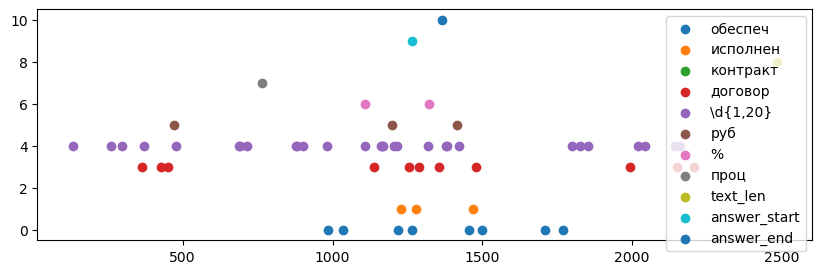

Индекс строки DataFrame: 808


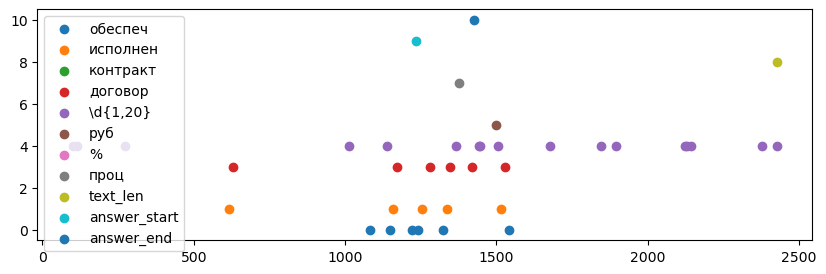

Индекс строки DataFrame: 45


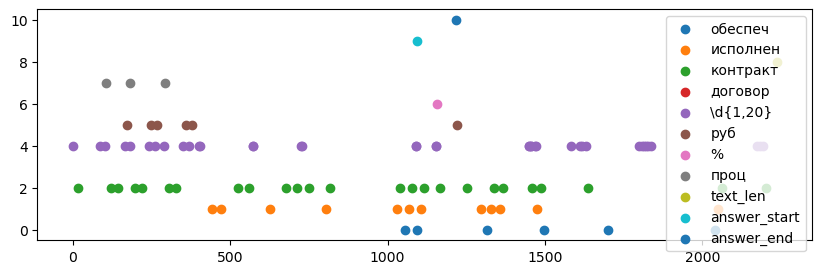

Индекс строки DataFrame: 173


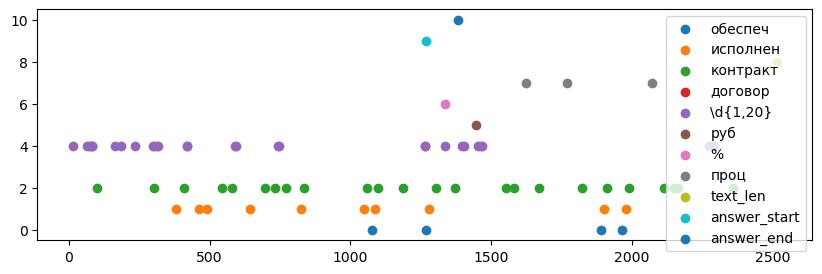

Индекс строки DataFrame: 481


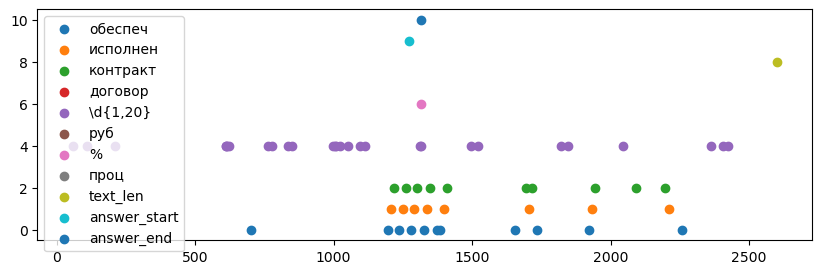

Индекс строки DataFrame: 749


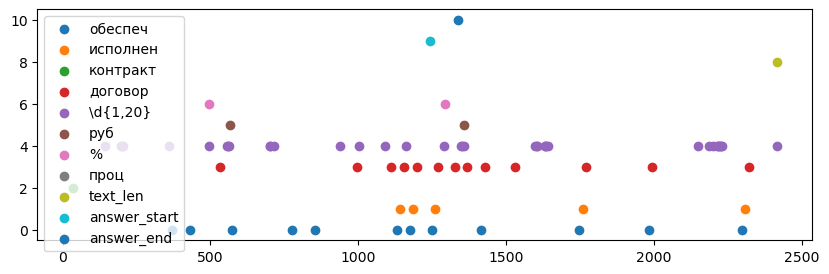

Индекс строки DataFrame: 404


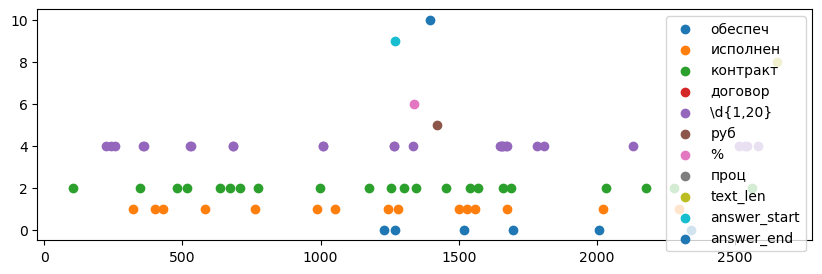

Индекс строки DataFrame: 312


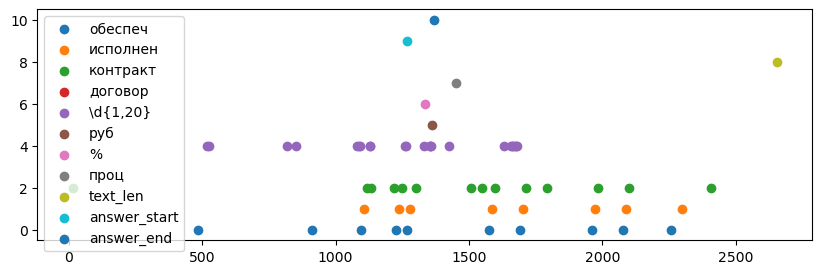

Индекс строки DataFrame: 551


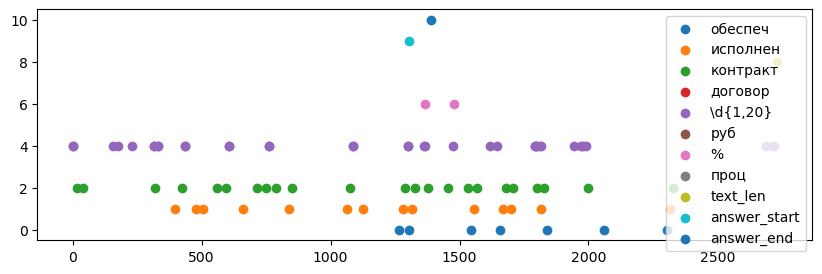

Индекс строки DataFrame: 830


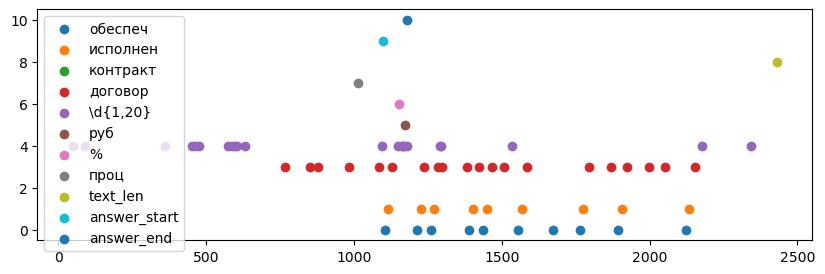

Индекс строки DataFrame: 754


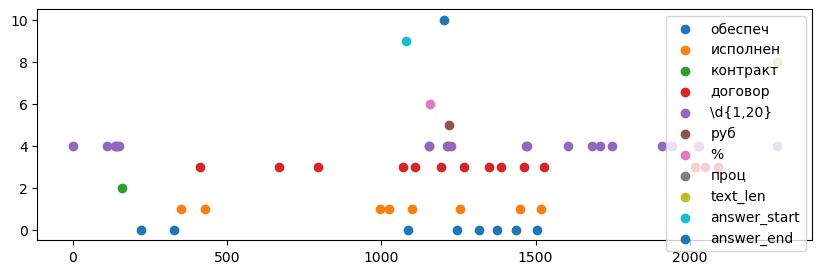

Индекс строки DataFrame: 682


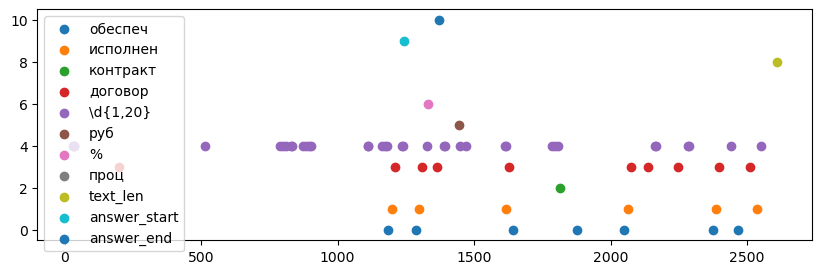

Индекс строки DataFrame: 322


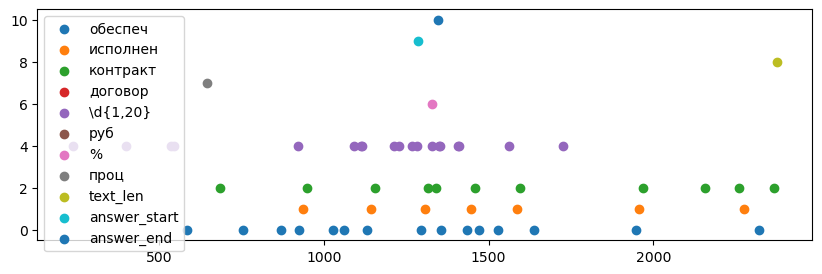

Индекс строки DataFrame: 532


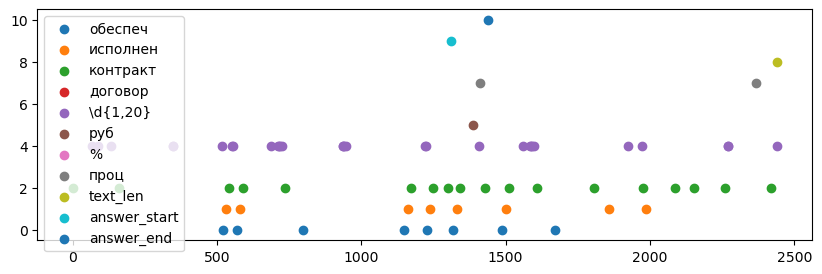

Индекс строки DataFrame: 623


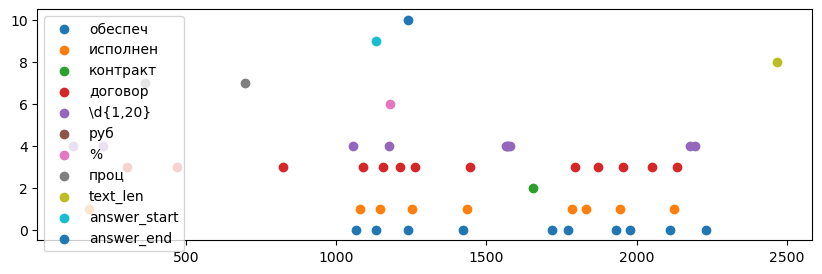

Индекс строки DataFrame: 161


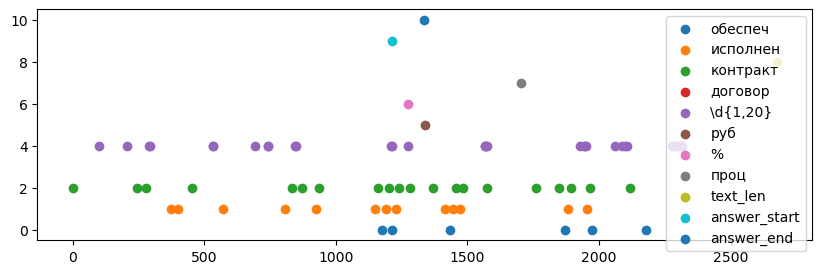

Индекс строки DataFrame: 245


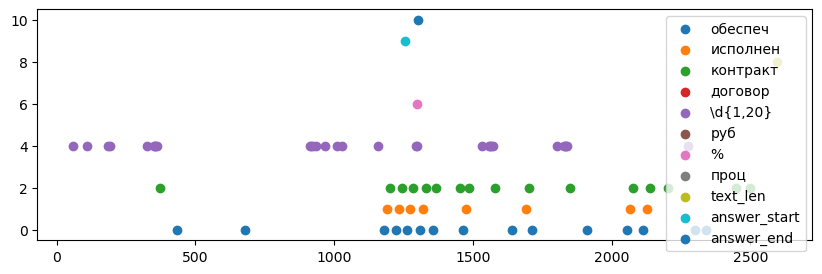

Индекс строки DataFrame: 32


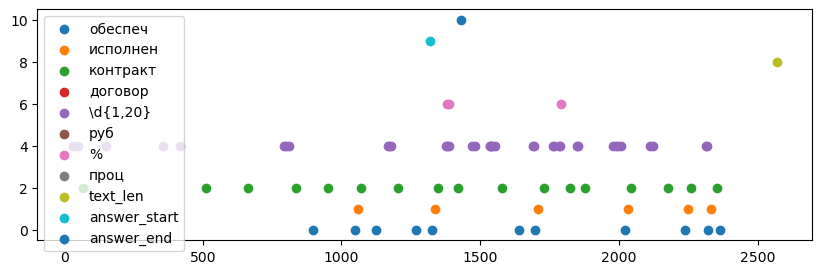

Индекс строки DataFrame: 582


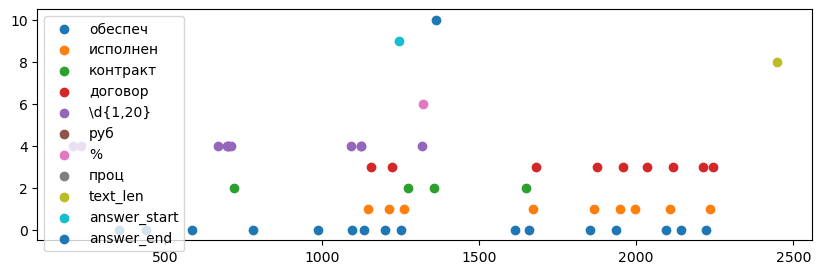

Индекс строки DataFrame: 508


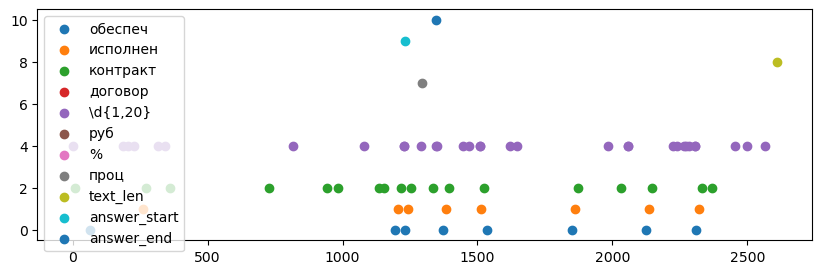

In [52]:
words_for_places = ['обеспеч','исполнен','контракт','договор','\d{1,20}','руб','%','проц']

graph_words_places_in_text(train_0, words_for_places)
#graph_words_places_in_text(train_0, special_words_0)

Перебирая индексы и рассматривая картинки, видно:

1) в `extracted_part` регулярно попадают ("обеспеч", "исполнен", "число", "контракт" или "договор", "руб" или "%" или "проц"),

2) в тексте таких ситуаций порядка 1-3.

3) практически все `answer_start`, `answer_end` расположены в диапазоне 1000 - 1500 (уточнить минимум, максимум и распределение!), похоже на сильный признак, надеюсь в test это распределение сохраняется (разбивка train/test сделана честно).

4) подумать над вариантом модельки для определения локации для поиска фрагмента (start - end) или регулярные выражения???

#### label = 1

Графики расположения ключевых слов в тексте (для 20-ти случайных текстов для label=1).

Индекс строки DataFrame: 299


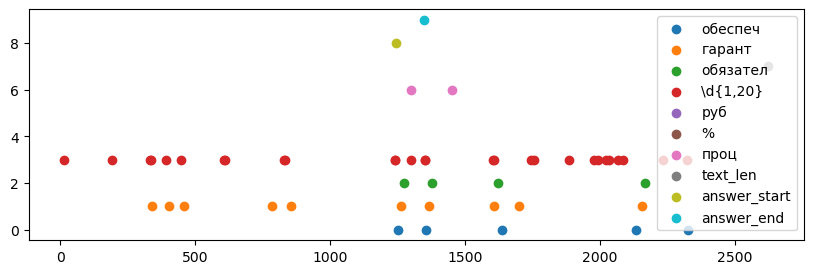

Индекс строки DataFrame: 86


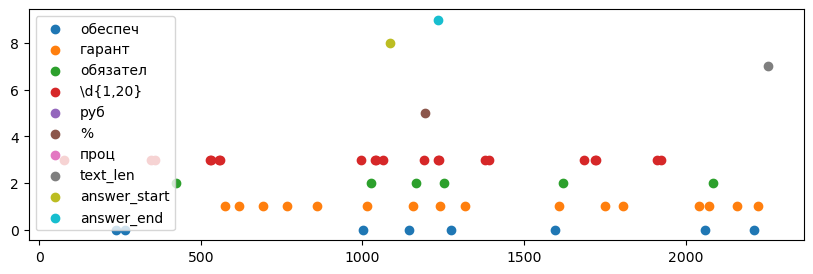

Индекс строки DataFrame: 651


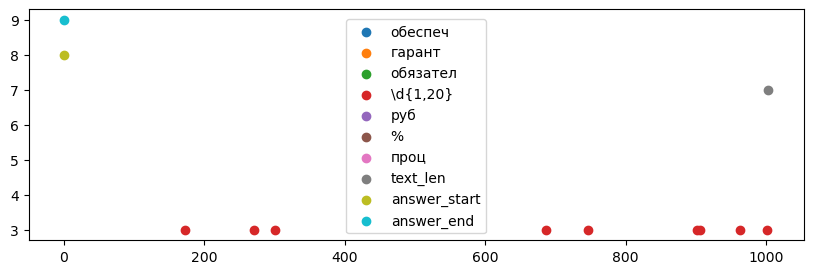

Индекс строки DataFrame: 314


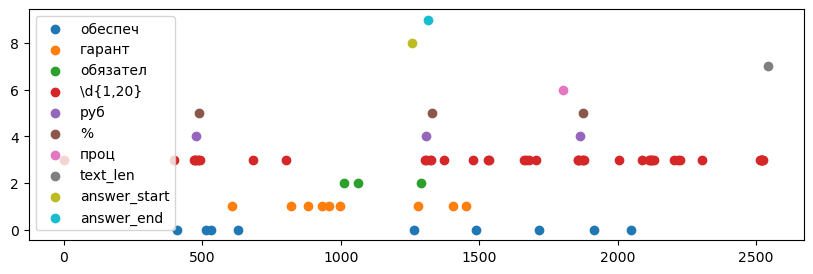

Индекс строки DataFrame: 321


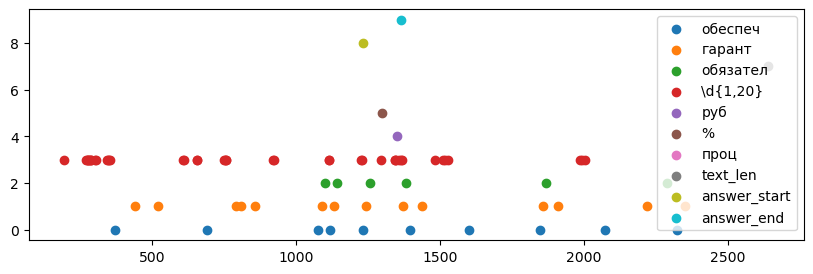

Индекс строки DataFrame: 163


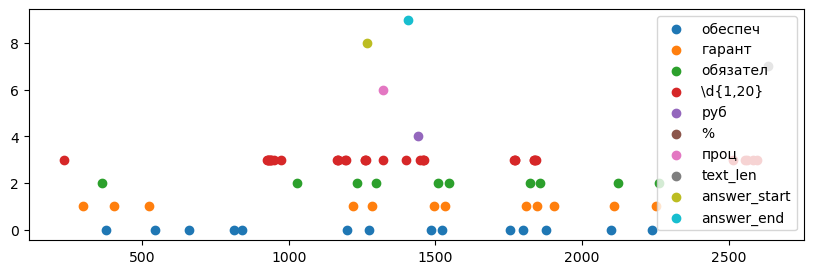

Индекс строки DataFrame: 737


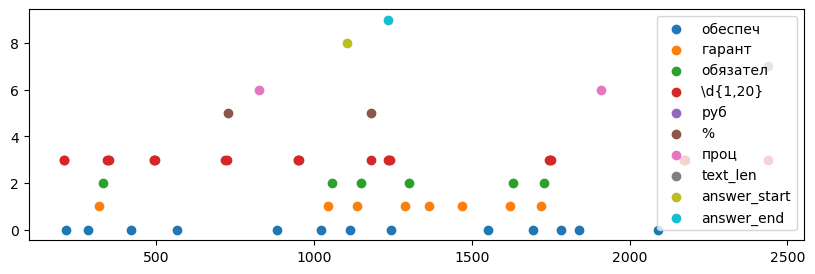

Индекс строки DataFrame: 579


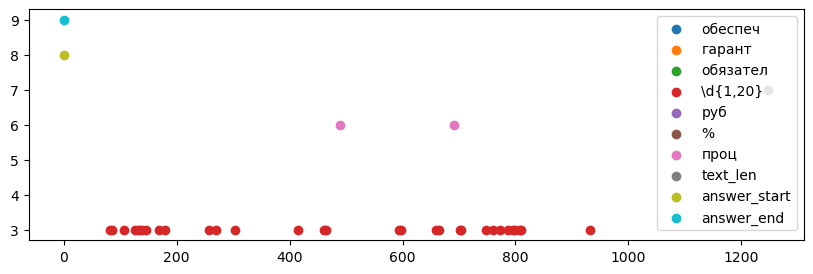

Индекс строки DataFrame: 787


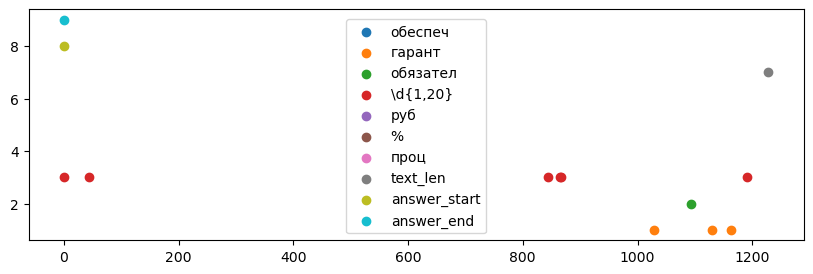

Индекс строки DataFrame: 271


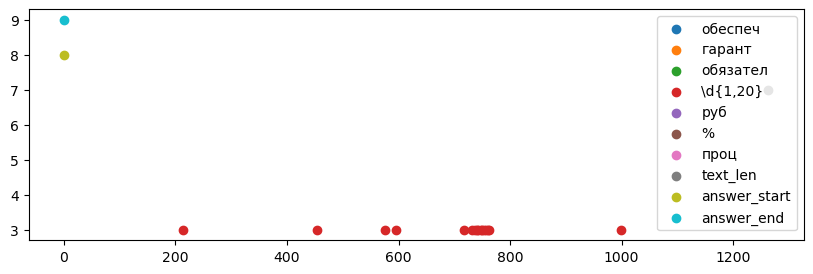

Индекс строки DataFrame: 286


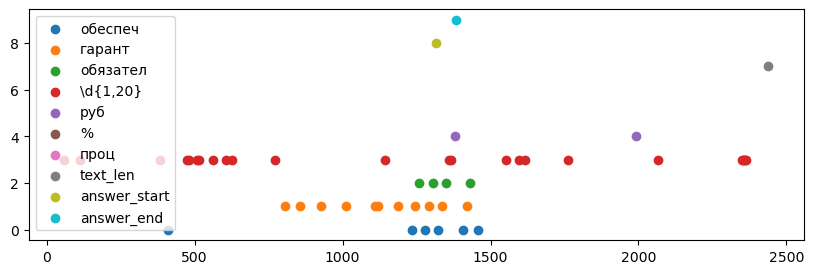

Индекс строки DataFrame: 343


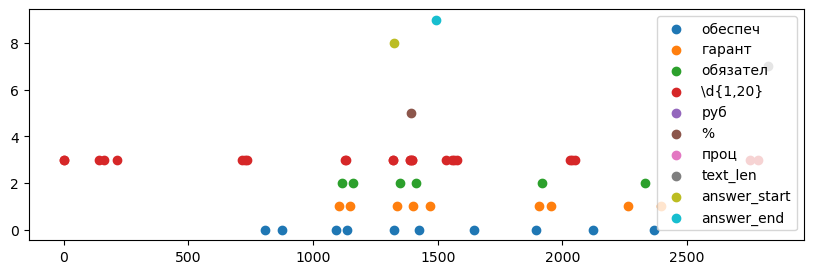

Индекс строки DataFrame: 689


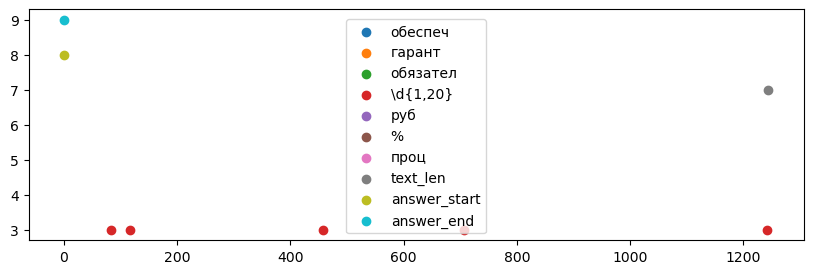

Индекс строки DataFrame: 782


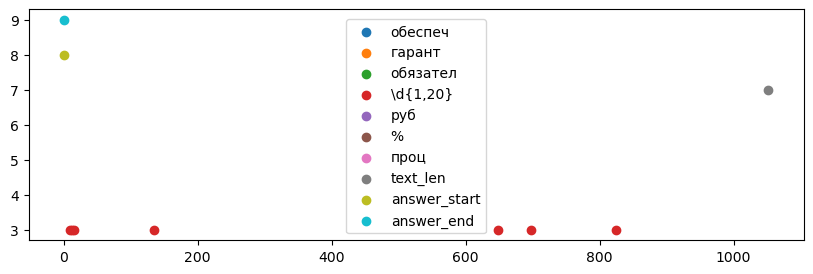

Индекс строки DataFrame: 252


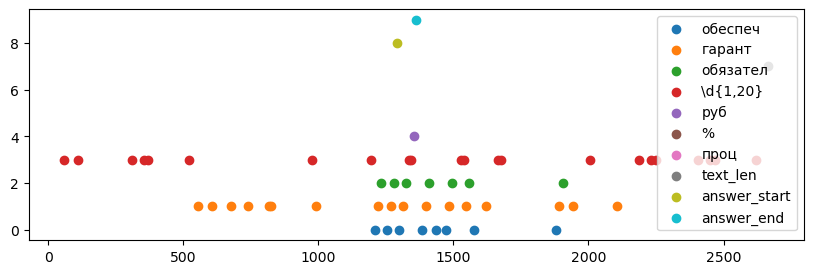

Индекс строки DataFrame: 4


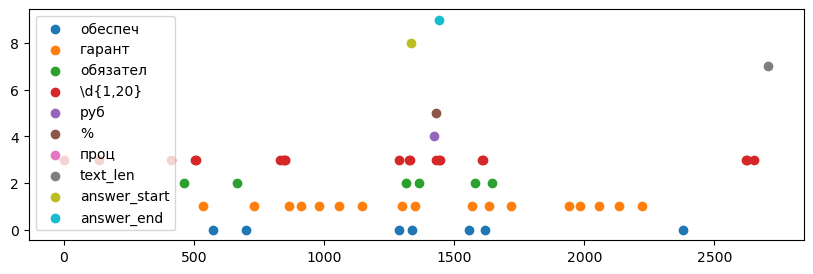

Индекс строки DataFrame: 318


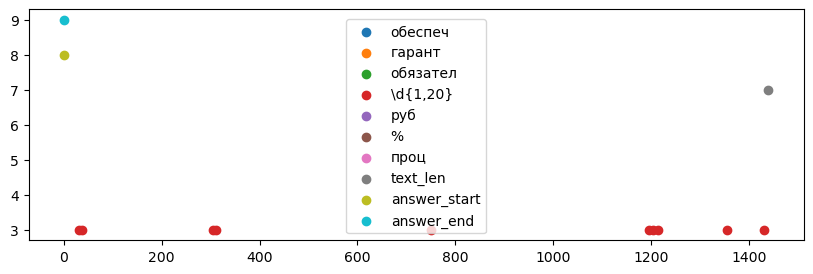

Индекс строки DataFrame: 316


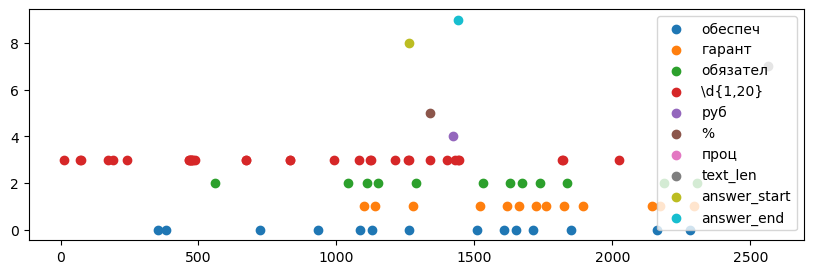

Индекс строки DataFrame: 729


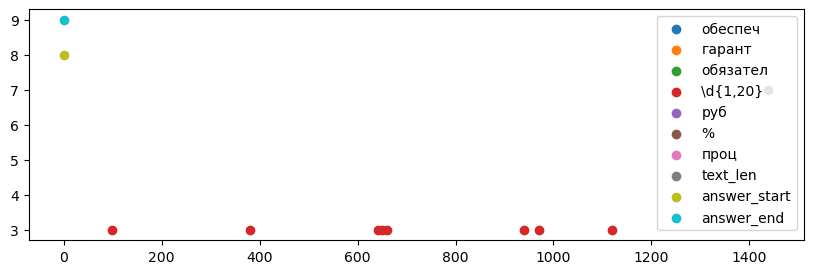

Индекс строки DataFrame: 257


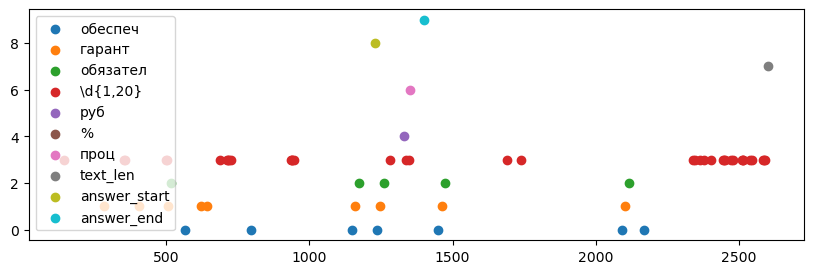

In [53]:
words_for_places = ['обеспеч','гарант','обязател','\d{1,20}','руб','%','проц']

graph_words_places_in_text(train_1, words_for_places)
#graph_words_places_in_text(train_0, special_words_1)

Перебирая индексы и рассматривая картинки, видно:

1) в `extracted_part` регулярно попадают ("обеспеч", "гарант", "число", "обязател", "руб" или "%" или "проц"),

2) в тексте таких ситуаций порядка 1-2.

3) практически все `answer_start`, `answer_end` расположены в диапазоне 1000 - 1500 (уточнить распределение!), похоже на сильный признак, надеюсь в test это распределение сохраняется (разбивка train/test сделана честно).

4) сильная зависимость длинны текста от наличия или отсутствия фрагмента: длинна текста без фрагмента не более 1500, длинна текста с фрагментом более 2000 (уточнить распределение). Похоже на сильный признак определения текстов без фрагментов.

5) подумать над вариантом модельки для определения локации для поиска фрагмента (start - end) или регулярные выражения???

### Распределение `answer_start`, `answer_end`

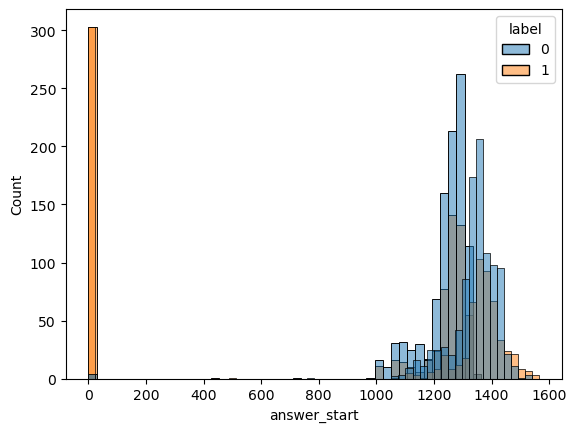

In [54]:
sns.histplot(data=train, x='answer_start', hue='label')
sns.histplot(data=train, x='answer_end', hue='label')
plt.show()

Распределение подтверждает предположение, о том, что не пустые фрагменты сосредоточены в диапазоне 1000-1600 (имеются незначительные выбросы в диапазоне 400-1000). Имеено там нужно искать правильные фрагменты.

### Распределение длинны текста относительно наличия/отсутствия фрагмента

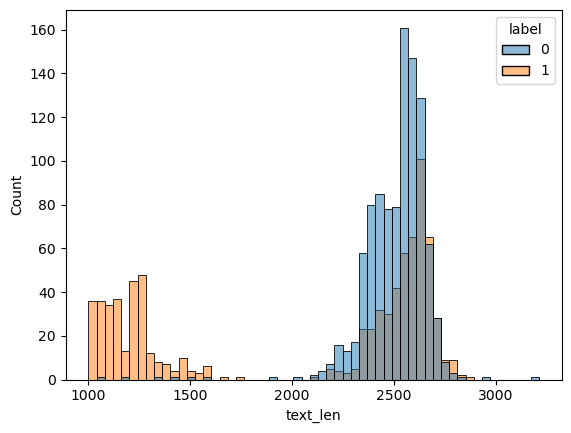

In [55]:
sns.histplot(data=train, x='text_len', hue='label')
plt.show()

###### Распределение длины текста имеет отличия для `label`:

1) `label`=0, длина сосредоточена в диапазоне 2000-3000,

2) `label`=1, длина сосредоточена в двух диапазонах: 1000 - 1600, 2000 - 3000.

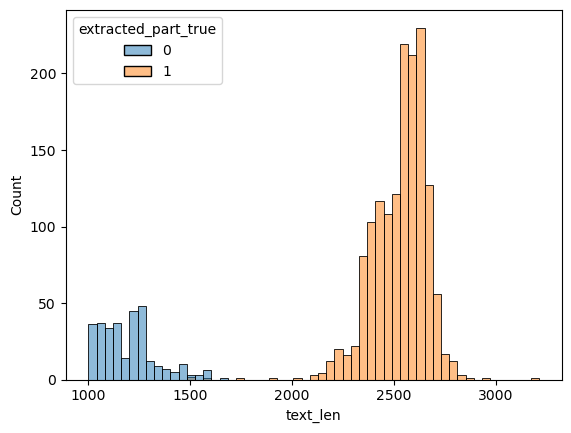

In [56]:
sns.histplot(data=train, x='text_len', hue='extracted_part_true')
plt.show()

Распределение подтверждает предположение, о том, что длина текста практически однозначно разделяет тексты с фрагментами и без. Граница порядка 1600 символов (имеется пара выбросов).

### Кореляция Пирсона между числовыми признаками

Без строк с пустыми фрагментами, они ненужны для анализа, так как однозначно вычисляются по длинне текста. Но при этом будут сильно влиять на корреляцию.

In [57]:
train.query('extracted_part_true == 1').corr()

,id,label,answer_start,answer_end,extracted_part_true,text_len,extracted_part_len
id,1.000000,0.025763,-0.026417,-0.001212,NaN,0.031040,0.041625
label,0.025763,1.000000,0.021381,0.139827,NaN,0.150899,0.211374
answer_start,-0.026417,0.021381,1.000000,0.831011,NaN,0.616328,-0.189933
answer_end,-0.001212,0.139827,0.831011,1.000000,NaN,0.637114,0.388294
extracted_part_true,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text_len,0.031040,0.150899,0.616328,0.637114,NaN,1.000000,0.103458
extracted_part_len,0.041625,0.211374,-0.189933,0.388294,NaN,0.103458,1.000000


Имеется зависимость `answer_start` и `answer_end` от `text_len`.

## Выводы по анализу

1) Анализ количества текстов с отсутствующим фрагментом (слово "пустота"):

    - незначительно для label `обеспечение исполнения контракта`,
    - значительно для label `обеспечение гарантийных обязательств`,
    Это может помочь в определении текстов с пустыми фрагментами.

2) Для текство с отсутствующими фрагментами хорошо видна зависимость на отсутствие слов из `label`:

    - для label `обеспечение исполнения контракта` - для оценки мало пустых фрагментов,
    - для label `обеспечение гарантийных обязательств` - слова: "гарантийный+обязательство" практически гарантируют отсутствие,

3) Частота встречаемости ключевых слов в фрагментах значительно отличается:

    - `гарантийный, обязательство` практически не встречается в label `обеспечение исполнения контракта`,
    - `исполнение` является редким в label `обеспечение гарантийных обязательств`.
    Похоже для разных `label`, нужны разные модели. Но имеются ограничения по объёму данных, может не хватить для обучения.
    
4) Имеются устойчивые регулярные фрагменты для обоих `label`. Их стоит определять напрямую без модели.

5) Тексты с отсутствующими фрагментами однозначно определяются по длине текста: граница 1600 символов.

6) Не пустые фрагменты текстов расположены в диапазоне 1000-1600 символов. (границы для `answer_start`, `answer_end`)

## Примерный план решение

План решения (повторяется для каждого `label` с некоторыми отличиями):

1) лемматизировать `text` функцией `lemmatize`, получить столбец `words_lemmatize`,

2) разделить данные на две таблицы по `label`,

3) определить тексты с отсутствующим фрагментом по лематизированным столбцам `words_lemmatize` или `text_len` < 1600 :

    - для label `обеспечение исполнения контракта` - одновременно отсутствуют: "исполнение+контракт",
    - для label `обеспечение гарантийных обязательств` - одновременно отсутствуют: "гарантийный+обязательство",
    
4) Проверить наличие наиболее частых регулярных фрагментов в текстах:

     - для label `обеспечение исполнения контракта` - взять из `train_0_regular_part`
     - для label `обеспечение гарантийных обязательств` - взять из `train_1_regular_part`
     
5) Удалить тексты с предиктами: отсутствующие фрагменты + регулярные фрагменты.

6) Каким то образом (регулярные выражения? вхождение ключевых слов?, модель?) из оставшихся текстов сгенерировать порядка 10-ти наиболее вероятных фрагментов:

    - ключевые слова обязательно входят:
        а) для label `обеспечение исполнения контракта`
            ("обеспеч", "исполнен", "число", "контракт" или "договор", "руб" или "%" или "проц")
        б) для label `обеспечение гарантийных обязательств`
            ("обеспеч", "гарант", "число", "обязател", "руб" или "%" или "проц")
        в) добавить special_words, специфичные для фрагментов.
    - фрагменты текстов расположены в диапазоне 1000-1600 символов.
    - имеется зависимость `answer_start` и `answer_end` от `text_len` порядка 0.6.

7) получить эмбеддинги (BERT?) данных фрагментов,

8) обучить бустинг(почему не нейронка, данные однородные?) на определение верного фрагмента из 10 (несбалансированная классификация? метрика ROC-AUC?)

9) ответ будет суммой: отсутствующие фрагменты + регулярные фрагменты + фрагменты выбранные бустингом (нейронкой?).

## Моделирование решения на train

### Выделим валидационную выборку из train, применим стратификацию по полю `label`.

In [58]:
train, valid = train_test_split(train, stratify=train['label'], test_size=0.25, random_state=RANDOM_SEED)
train.shape, valid.shape

((1349, 16), (450, 16))

### лемматизировать `text` функцией `lemmatize`, получить столбец `words_lemmatize`

выполнено в предобработке

### разделить данные на две таблицы по `label`

In [59]:
train_0 = train.query('label == 0').reset_index(drop=True)
valid_0 = valid.query('label == 0').reset_index(drop=True)
train_1 = train.query('label == 1').reset_index(drop=True)
valid_1 = valid.query('label == 1').reset_index(drop=True)
train_0.shape, valid_0.shape, train_1.shape, valid_1.shape,

((741, 16), (247, 16), (608, 16), (203, 16))

### Предсказание отсутствующие фрагменты

In [60]:
# Функция принимает строку(words_lemmatize и длину текста) и список из 2-х слов,
# осуществляет проверку на вхождение этих слов одновременно в words_lemmatize
# и проверку длины текста,
# возвращает predict (пустое список или длина текста < 1700), либо None

def check_empty_fragment(row, words):
    
    # слова не входят или длина текста < 1600, вернуть predict
    if (len(set(row['words_lemmatize']) & set(words)) == 0) or (row['text_len'] < 1600):  
        return {'text': [''], 'answer_start': [0], 'answer_end': [0]}
    else:   # входит хотябы одно слово, вернуть None
        return None
        

#### Применение функции

In [61]:
control_words_0 = ['исполнение', 'контракт']
control_words_1 = ['гарантийный', 'обязательство']

valid_0['extracted_part_predict'] = valid_0.apply(check_empty_fragment, axis=1, words=control_words_0)
valid_1['extracted_part_predict'] = valid_1.apply(check_empty_fragment, axis=1, words=control_words_1)
train_0['extracted_part_predict'] = train_0.apply(check_empty_fragment, axis=1, words=control_words_0)
train_1['extracted_part_predict'] = train_1.apply(check_empty_fragment, axis=1, words=control_words_1)

#### Отделение предсказанных данных

In [62]:
valid_0_predict_empty = valid_0[~valid_0['extracted_part_predict'].isna()][['id','text','label','extracted_part','extracted_part_predict']]
valid_0 = valid_0.drop(valid_0_predict_empty.index)
valid_1_predict_empty = valid_1[~valid_1['extracted_part_predict'].isna()][['id','text','label','extracted_part','extracted_part_predict']]
valid_1 = valid_1.drop(valid_1_predict_empty.index)
train_0_predict_empty = train_0[~train_0['extracted_part_predict'].isna()][['id','text','label','extracted_part','extracted_part_predict']]
train_0 = train_0.drop(train_0_predict_empty.index)
train_1_predict_empty = train_1[~train_1['extracted_part_predict'].isna()][['id','text','label','extracted_part','extracted_part_predict']]
train_1 = train_1.drop(train_1_predict_empty.index)

In [63]:
print(f' Размер valid_0_predict_empty: {valid_0_predict_empty.shape[0]}\n',
      f'Размер valid_1_predict_empty: {valid_1_predict_empty.shape[0]}\n',
      f'Размер valid_0: {valid_0.shape[0]}\n',
      f'Размер valid_1: {valid_1.shape[0]}',
     )

 Размер valid_0_predict_empty: 2
 Размер valid_1_predict_empty: 75
 Размер valid_0: 245
 Размер valid_1: 128


### Предсказание регулярные фрагменты

In [64]:
# Функция принимает text и список регулярных фрагментов,
# осуществляет проверку на вхождение данных фрагментов,
# возвращает predict (фрагмент и координаты), либо None

def check_regular_fragment(text, parts):
    
    for part in parts:
        first_index = text.find(part)
        if first_index != -1:
            return {'text': [part], 'answer_start': [first_index], 'answer_end': [first_index+len(part)]}
     
    return None   # не входит ни один фрагмент, вернуть None

#### Применение функции

In [65]:
valid_0['extracted_part_predict'] = valid_0['text'].apply(check_regular_fragment, parts=regular_parts_0)
valid_1['extracted_part_predict'] = valid_1['text'].apply(check_regular_fragment, parts=regular_parts_1)
train_0['extracted_part_predict'] = train_0['text'].apply(check_regular_fragment, parts=regular_parts_0)
train_1['extracted_part_predict'] = train_1['text'].apply(check_regular_fragment, parts=regular_parts_1)

#### Отделение предсказанных данных

In [66]:
valid_0_predict_regular = valid_0[~valid_0['extracted_part_predict'].isna()][['id','text','label','extracted_part','extracted_part_predict']]
valid_0 = valid_0.drop(valid_0_predict_regular.index)
valid_1_predict_regular = valid_1[~valid_1['extracted_part_predict'].isna()][['id','text','label','extracted_part','extracted_part_predict']]
valid_1 = valid_1.drop(valid_1_predict_regular.index)
train_0_predict_regular = train_0[~train_0['extracted_part_predict'].isna()][['id','text','label','extracted_part','extracted_part_predict']]
train_0 = train_0.drop(train_0_predict_regular.index)
train_1_predict_regular = train_1[~train_1['extracted_part_predict'].isna()][['id','text','label','extracted_part','extracted_part_predict']]
train_1 = train_1.drop(train_1_predict_regular.index)

In [67]:
print(f' Размер valid_0_predict_regular: {valid_0_predict_regular.shape[0]}\n',
      f'Размер valid_1_predict_regular: {valid_1_predict_regular.shape[0]}\n',
      f'Размер valid_0: {valid_0.shape[0]}\n',
      f'Размер valid_1: {valid_1.shape[0]}',
     )

 Размер valid_0_predict_regular: 59
 Размер valid_1_predict_regular: 0
 Размер valid_0: 186
 Размер valid_1: 128


### Получим признак "положение ключевых слов в диапазоне 1000-1600"

**1) выбрать положение ключевых слов**

**2) построить DataFrame c переводом word в столбцы, количество строк равно длине текста, в каждой строке помечены вхождения слов (1), в остальных ячейках (0).**

**3) Применить maxpool к столбцам для уплотнения признаков, а затем flatten. Получится признак для модели предсказания примерной локализации 'answer_start' и 'answer_end'**

In [68]:
pool_kernel_size = 40
maxpool = torch.nn.MaxPool1d(pool_kernel_size)

# Функция созадет признаки на основании вхождения ключевых слов в text,
# уплотняет признаковое пространство методом maxpool.
# возвращает numpy вектор.
def create_feature_for_places(text, words_for_places, words_for_places_removed, maxpool):

    # 1 пункт
    # датафрейм ключевых слов с позициями в тексте.
    # удаляется последняя строка датафрейма с информацией о длине текста ('text_len')
    df_words_places_in_text = words_places_in_text(text, words_for_places)[:-1]
    

    # 2 пункт
    # датафрейм подложка заполненная 0, размер (число символов в тексте, число ключевых слов) 
    df_words_places_in_text_new = pd.DataFrame(np.zeros([len(text), df_words_places_in_text['word'].shape[0]], dtype=int),
                 columns= df_words_places_in_text['word'])
    # заполнение датафрейма ключевыми словами в месте их вхождения
    for word in words_for_places:
        index_word_list = df_words_places_in_text.query(f'word == @word').values[0][1]
        for index in index_word_list:
            df_words_places_in_text_new.loc[index,word] = 1

    # обрезка размера столбцов под область обнаружения строки (область определена из анализа)
    df_words_places_in_text_new = df_words_places_in_text_new[1000:1600]

    # Объединение колонок синонимов "контракт+договор" (при наличии), "руб+%+проц" 
    if 'договор' in words_for_places:
        df_words_places_in_text_new['контракт'] = df_words_places_in_text_new['контракт'] + df_words_places_in_text_new['договор']
        df_words_places_in_text_new.drop(columns=['договор'], inplace=True)
    df_words_places_in_text_new['руб'] = df_words_places_in_text_new['руб'] + df_words_places_in_text_new['%'] + df_words_places_in_text_new['проц']
    df_words_places_in_text_new.drop(columns=['%','проц'], inplace=True)

    # 3 пункт
    #words_for_places_removed_words = words_for_places
    tensor = torch.tensor(df_words_places_in_text_new[words_for_places_removed].values, dtype=float).T
    
    return torch.flatten(maxpool(tensor)).numpy()

In [69]:
# words_for_places_0 = ['обеспеч','исполнен','контракт','договор','\d{1,20}','руб','%','проц']
# words_for_places_removed_0 = ['обеспеч','исполнен','контракт','\d{1,20}','руб']
words_for_places_0 = ['обеспеч','исполнен','контракт','договор','\d{1,20}','руб','%','проц','размер','цена','максимал','начальн','составл']
words_for_places_removed_0 = ['обеспеч','исполнен','контракт','\d{1,20}','руб','размер','цена','максимал','начальн','составл']

feature_len_0 = int(600*len(words_for_places_removed_0)/pool_kernel_size)

In [70]:
train_0_feature_for_places = train_0[['id','answer_start','answer_end','text_len']]
train_0_feature_for_places['features'] = train_0['text_lower'].apply(create_feature_for_places, 
                                                               words_for_places=words_for_places_0,
                                                               words_for_places_removed=words_for_places_removed_0,
                                                               maxpool=maxpool                                                              
                                                              )
train_0_feature_for_places = pd.concat([train_0_feature_for_places, 
                                        pd.DataFrame(np.reshape(np.concatenate(train_0_feature_for_places['features'].values), 
                                                                (-1,feature_len_0)), index=train_0_feature_for_places.index,
                                                     columns=['feature_'+str(i) for i in range(feature_len_0)]
                                                    )],
                                       axis=1).drop(columns=['features'])



In [71]:
train_0_feature_for_places.head(3)

,id,answer_start,answer_end,text_len,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149
0,552828775,1202,1380,2490,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,617876244,1159,1306,2453,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,755785452,1299,1395,2506,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [72]:
valid_0_feature_for_places = valid_0[['id','answer_start','answer_end','text_len']]
valid_0_feature_for_places['features'] = valid_0['text_lower'].apply(create_feature_for_places, 
                                                               words_for_places=words_for_places_0,
                                                               words_for_places_removed=words_for_places_removed_0,
                                                               maxpool=maxpool                                                              
                                                              )
valid_0_feature_for_places = pd.concat([valid_0_feature_for_places, 
                                        pd.DataFrame(np.reshape(np.concatenate(valid_0_feature_for_places['features'].values), 
                                                                (-1,feature_len_0)), index=valid_0_feature_for_places.index,
                                                     columns=['feature_'+str(i) for i in range(feature_len_0)]
                                                    )],
                                       axis=1).drop(columns=['features'])

In [73]:
valid_0_feature_for_places.head(3)

,id,answer_start,answer_end,text_len,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149
2,508536913,1288,1352,2566,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25937508,1255,1387,2580,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,625224946,1322,1386,2683,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
# words_for_places_1 = ['обеспеч','гарант','обязател','\d{1,20}','руб','%','проц']
# words_for_places_removed_1 = ['обеспеч','гарант','обязател','\d{1,20}','руб']
words_for_places_1 = ['обеспеч','гарант','обязател','\d{1,20}','руб','%','проц','размер','максимальный','начальный','цена','составлять','российский','устанавливаться']
words_for_places_removed_1 = ['обеспеч','гарант','обязател','\d{1,20}','руб','размер','максимальный','начальный','цена','составлять','российский','устанавливаться']
feature_len_1 = int(600*len(words_for_places_removed_1)/pool_kernel_size)

In [75]:
train_1_feature_for_places = train_1[['id','answer_start','answer_end','text_len']]
train_1_feature_for_places['features'] = train_1['text_lower'].apply(create_feature_for_places, 
                                                               words_for_places=words_for_places_1,
                                                               words_for_places_removed=words_for_places_removed_1,
                                                               maxpool=maxpool                                                              
                                                              )
train_1_feature_for_places = pd.concat([train_1_feature_for_places, 
                                        pd.DataFrame(np.reshape(np.concatenate(train_1_feature_for_places['features'].values), 
                                                                (-1,feature_len_1)), index=train_1_feature_for_places.index,
                                                     columns=['feature_'+str(i) for i in range(feature_len_1)]
                                                    )],
                                       axis=1).drop(columns=['features'])

In [76]:
train_1_feature_for_places.head(3)

,id,answer_start,answer_end,text_len,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179
0,843063767,1303,1449,2497,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,112019945,1250,1417,2459,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,110850447,1246,1413,2559,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
valid_1_feature_for_places = valid_1[['id','answer_start','answer_end','text_len']]
valid_1_feature_for_places['features'] = valid_1['text_lower'].apply(create_feature_for_places, 
                                                               words_for_places=words_for_places_1,
                                                               words_for_places_removed=words_for_places_removed_1,
                                                               maxpool=maxpool                                                              
                                                              )
valid_1_feature_for_places = pd.concat([valid_1_feature_for_places, 
                                        pd.DataFrame(np.reshape(np.concatenate(valid_1_feature_for_places['features'].values), 
                                                                (-1,feature_len_1)), index=valid_1_feature_for_places.index,
                                                     columns=['feature_'+str(i) for i in range(feature_len_1)]
                                                    )],
                                       axis=1).drop(columns=['features'])

In [78]:
valid_1_feature_for_places.head(3)

,id,answer_start,answer_end,text_len,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179
5,50804841,1294,1362,2638,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,253992575,1174,1243,2475,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,318636442,1300,1434,2686,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Обучение catboost `answer_start_near`, `answer_end_near`

In [79]:
pool_train_0_start = Pool(data=train_0_feature_for_places.drop(columns=['id','answer_start','answer_end']),
                          label=train_0_feature_for_places['answer_start'])
pool_valid_0_start = Pool(data=valid_0_feature_for_places.drop(columns=['id','answer_start','answer_end']),
                          label=valid_0_feature_for_places['answer_start'])
pool_train_1_start = Pool(data=train_1_feature_for_places.drop(columns=['id','answer_start','answer_end']),
                          label=train_1_feature_for_places['answer_start'])
pool_valid_1_start = Pool(data=valid_1_feature_for_places.drop(columns=['id','answer_start','answer_end']),
                          label=valid_1_feature_for_places['answer_start'])

pool_train_0_end = Pool(data=train_0_feature_for_places.drop(columns=['id','answer_start','answer_end']),
                          label=train_0_feature_for_places['answer_end'])
pool_valid_0_end = Pool(data=valid_0_feature_for_places.drop(columns=['id','answer_start','answer_end']),
                          label=valid_0_feature_for_places['answer_end'])
pool_train_1_end = Pool(data=train_1_feature_for_places.drop(columns=['id','answer_start','answer_end']),
                          label=train_1_feature_for_places['answer_end'])
pool_valid_1_end = Pool(data=valid_1_feature_for_places.drop(columns=['id','answer_start','answer_end']),
                          label=valid_1_feature_for_places['answer_end'])

In [80]:
model_for_places_0_start = CatBoostRegressor(iterations=500,
                                       learning_rate=0.1,
                                       depth=4,
                                       loss_function='RMSE',
                                       eval_metric='MAE',
                                       task_type = 'CPU',
                                       random_state=RANDOM_SEED,
                                       #train_dir = "model_for_places_0_start",
                                      )
model_for_places_0_start.fit(
    pool_train_0_start,
    eval_set=(pool_valid_0_start),
    verbose=100,
    #plot=True,
    )

0:	learn: 55.1255235	test: 51.5743079	best: 51.5743079 (0)	total: 176ms	remaining: 1m 27s
100:	learn: 15.5270166	test: 22.4194169	best: 22.4194169 (100)	total: 1.76s	remaining: 6.95s
200:	learn: 10.7228192	test: 20.7952996	best: 20.7951685 (199)	total: 3.23s	remaining: 4.81s
300:	learn: 8.1525144	test: 20.4312758	best: 20.4312758 (300)	total: 4.73s	remaining: 3.13s
400:	learn: 6.2566876	test: 20.1230792	best: 20.1230792 (400)	total: 6.27s	remaining: 1.55s
499:	learn: 4.8634380	test: 19.8432418	best: 19.8340652 (498)	total: 7.73s	remaining: 0us

bestTest = 19.83406523
bestIteration = 498

Shrink model to first 499 iterations.


In [81]:
model_for_places_1_start = CatBoostRegressor(iterations=500,
                                       learning_rate=0.1,
                                       depth=3,
                                       loss_function='RMSE',
                                       eval_metric='MAE',
                                       task_type = 'CPU',
                                       random_state=RANDOM_SEED,
                                       #train_dir = "model_for_places_1_start",
                                      )
model_for_places_1_start.fit(
    pool_train_1_start,
    eval_set=(pool_valid_1_start),
    verbose=100,
    #plot=True,
    )

0:	learn: 47.1375282	test: 48.6085151	best: 48.6085151 (0)	total: 499us	remaining: 249ms
100:	learn: 16.1817807	test: 30.6052735	best: 30.6052735 (100)	total: 44.2ms	remaining: 174ms
200:	learn: 10.8321940	test: 28.2949352	best: 28.2849742 (199)	total: 87.4ms	remaining: 130ms
300:	learn: 8.0696926	test: 27.5964054	best: 27.5602269 (298)	total: 129ms	remaining: 85.4ms
400:	learn: 6.4385672	test: 27.2157466	best: 27.1953111 (395)	total: 179ms	remaining: 44.2ms
499:	learn: 5.2421690	test: 26.9818439	best: 26.9501027 (496)	total: 224ms	remaining: 0us

bestTest = 26.95010267
bestIteration = 496

Shrink model to first 497 iterations.


In [82]:
model_for_places_0_end = CatBoostRegressor(iterations=500,
                                       learning_rate=0.1,
                                       depth=4,
                                       loss_function='RMSE',
                                       eval_metric='MAE',
                                       task_type = 'CPU',
                                       random_state=RANDOM_SEED,
                                       #train_dir = "model_for_places_0_end",
                                      )
model_for_places_0_end.fit(
    pool_train_0_end,
    eval_set=(pool_valid_0_end),
    verbose=100,
    #plot=True,
    )

0:	learn: 58.9857668	test: 52.8652758	best: 52.8652758 (0)	total: 14.6ms	remaining: 7.28s
100:	learn: 18.2840777	test: 25.2194856	best: 25.2194856 (100)	total: 1.43s	remaining: 5.64s
200:	learn: 12.1561327	test: 23.0083568	best: 22.9954322 (199)	total: 2.81s	remaining: 4.19s
300:	learn: 9.1531657	test: 22.4182466	best: 22.3778182 (296)	total: 4.29s	remaining: 2.83s
400:	learn: 7.1921473	test: 22.1720410	best: 22.1720410 (400)	total: 5.67s	remaining: 1.4s
499:	learn: 5.7445044	test: 21.9487126	best: 21.9452089 (498)	total: 7.04s	remaining: 0us

bestTest = 21.94520889
bestIteration = 498

Shrink model to first 499 iterations.


In [83]:
%%time
model_for_places_1_end = CatBoostRegressor(iterations=500,
                                       learning_rate=0.1,
                                       depth=3,
                                       loss_function='RMSE',
                                       eval_metric='MAE',
                                       task_type = 'CPU',
                                       random_state=RANDOM_SEED,
                                       #train_dir = "model_for_places_1_end",
                                      )
model_for_places_1_end.fit(
    pool_train_1_end,
    eval_set=(pool_valid_1_end),
    verbose=100,
    #plot=True,
    )

0:	learn: 52.3539402	test: 53.5584485	best: 53.5584485 (0)	total: 485us	remaining: 242ms
100:	learn: 21.2996443	test: 36.7357357	best: 36.7332607 (97)	total: 44.8ms	remaining: 177ms
200:	learn: 14.9400965	test: 34.7550058	best: 34.7550058 (200)	total: 90.8ms	remaining: 135ms
300:	learn: 11.6228112	test: 33.4141188	best: 33.4141188 (300)	total: 133ms	remaining: 88ms
400:	learn: 9.5870447	test: 33.2383690	best: 33.1453014 (386)	total: 177ms	remaining: 43.8ms
499:	learn: 8.1107223	test: 32.7877932	best: 32.7867715 (498)	total: 220ms	remaining: 0us

bestTest = 32.78677148
bestIteration = 498

Shrink model to first 499 iterations.
CPU times: total: 2.06 s
Wall time: 281 ms


**При обучении в большинстве случаев лучше всего себя показал `pool_kernel_size` = 40.**

#### Предсказание catboost `answer_start_near`, `answer_end_near`

In [84]:
valid_0_feature_for_places['answer_start_near'] = model_for_places_0_start.predict(valid_0_feature_for_places.drop(columns=['id','answer_start','answer_end'])).astype(int)
valid_0_feature_for_places['answer_end_near'] = model_for_places_0_end.predict(valid_0_feature_for_places.drop(columns=['id','answer_start','answer_end'])).astype(int)
valid_1_feature_for_places['answer_start_near'] = model_for_places_1_start.predict(valid_1_feature_for_places.drop(columns=['id','answer_start','answer_end'])).astype(int)
valid_1_feature_for_places['answer_end_near'] = model_for_places_1_end.predict(valid_1_feature_for_places.drop(columns=['id','answer_start','answer_end'])).astype(int)

train_0_feature_for_places['answer_start_near'] = model_for_places_0_start.predict(train_0_feature_for_places.drop(columns=['id','answer_start','answer_end'])).astype(int)
train_0_feature_for_places['answer_end_near'] = model_for_places_0_end.predict(train_0_feature_for_places.drop(columns=['id','answer_start','answer_end'])).astype(int)
train_1_feature_for_places['answer_start_near'] = model_for_places_1_start.predict(train_1_feature_for_places.drop(columns=['id','answer_start','answer_end'])).astype(int)
train_1_feature_for_places['answer_end_near'] = model_for_places_1_end.predict(train_1_feature_for_places.drop(columns=['id','answer_start','answer_end'])).astype(int)

In [85]:
columns = ['id','answer_start','answer_end','answer_start_near','answer_end_near']
valid_0_feature_for_places = valid_0_feature_for_places[columns]
valid_1_feature_for_places = valid_1_feature_for_places[columns]

train_0_feature_for_places = train_0_feature_for_places[columns]
train_1_feature_for_places = train_1_feature_for_places[columns]

Предсказание по тренировочным данным делается для сохранения порядка действий.

Последующие действия, по генерации подстрок не должно сказаться на качестве обучения предсказаний выбора строк.

##### Ошибка предсказания catboost `answer_start_near`, `answer_end_near`

In [86]:
valid_0_feature_for_places['answer_start_error'] = valid_0_feature_for_places['answer_start_near'] - valid_0_feature_for_places['answer_start']
valid_0_feature_for_places['answer_end_error'] = valid_0_feature_for_places['answer_end_near'] - valid_0_feature_for_places['answer_end']
valid_1_feature_for_places['answer_start_error'] = valid_1_feature_for_places['answer_start_near'] - valid_1_feature_for_places['answer_start']
valid_1_feature_for_places['answer_end_error'] = valid_1_feature_for_places['answer_end_near'] - valid_1_feature_for_places['answer_end']

Отрицательная ошибка - недооценка предсказаная.

Положительная ошибка - переоценка предсказания.

Распределение ошибки для label = 0

answer_start_error
Среднее значение : -3.4623655913978495, Стандартное отклонение : 29.26285687029834

answer_end_error
Среднее значение : 2.0591397849462365, Стандартное отклонение : 31.44968950668419


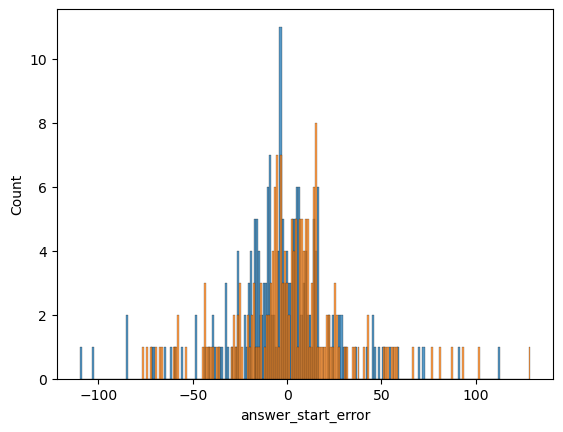

In [87]:
ax=sns.histplot(
    valid_0_feature_for_places,
    x='answer_start_error',
    bins=200
)
ax=sns.histplot(
    valid_0_feature_for_places,
    x='answer_end_error',
    bins=200
)

print(f'Распределение ошибки для label = 0\n')
print('answer_start_error')
print(f"Среднее значение : {valid_0_feature_for_places['answer_start_error'].mean()},",
      f"Стандартное отклонение : {valid_0_feature_for_places['answer_start_error'].std()}\n")

print('answer_end_error')
print(f"Среднее значение : {valid_0_feature_for_places['answer_end_error'].mean()},",
      f"Стандартное отклонение : {valid_0_feature_for_places['answer_end_error'].std()}")

Распределение ошибки для label = 1

answer_start_error
Среднее значение : 6.265625, Стандартное отклонение : 66.6790980453525

answer_end_error
Среднее значение : 6.6171875, Стандартное отклонение : 77.759585184661



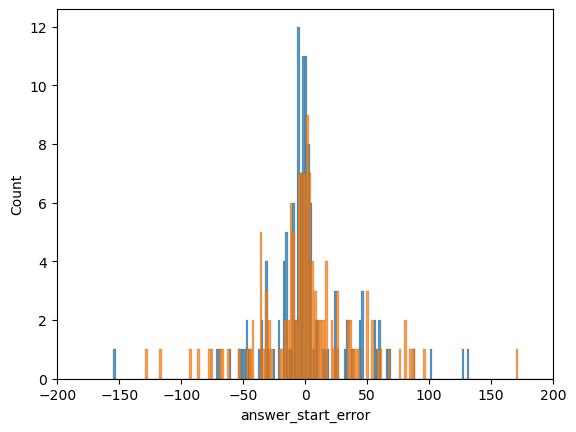

In [88]:
ax=sns.histplot(
    valid_1_feature_for_places,
    x='answer_start_error',
    bins=400
)
ax=sns.histplot(
    valid_1_feature_for_places,
    x='answer_end_error',
    bins=400
)
ax.set(xlim=(None, 200))

print(f'Распределение ошибки для label = 1\n')
print('answer_start_error')
print(f"Среднее значение : {valid_1_feature_for_places['answer_start_error'].mean()},",
      f"Стандартное отклонение : {valid_1_feature_for_places['answer_start_error'].std()}\n")

print('answer_end_error')
print(f"Среднее значение : {valid_1_feature_for_places['answer_end_error'].mean()},",
      f"Стандартное отклонение : {valid_1_feature_for_places['answer_end_error'].std()}\n")

In [89]:
valid_0_feature_for_places.head(3)

,id,answer_start,answer_end,answer_start_near,answer_end_near,answer_start_error,answer_end_error
2,508536913,1288,1352,1288,1356,0,4
4,25937508,1255,1387,1265,1361,10,-26
5,625224946,1322,1386,1310,1374,-12,-12


In [90]:
valid_1_feature_for_places.head(3)

,id,answer_start,answer_end,answer_start_near,answer_end_near,answer_start_error,answer_end_error
5,50804841,1294,1362,1297,1364,3,2
6,253992575,1174,1243,1242,1320,68,77
8,318636442,1300,1434,1265,1443,-35,9


In [91]:
valid_0[['answer_start_near','answer_end_near']] = valid_0_feature_for_places[['answer_start_near','answer_end_near']]
valid_1[['answer_start_near','answer_end_near']] = valid_1_feature_for_places[['answer_start_near','answer_end_near']]

train_0[['answer_start_near','answer_end_near']] = train_0_feature_for_places[['answer_start_near','answer_end_near']]
train_1[['answer_start_near','answer_end_near']] = train_1_feature_for_places[['answer_start_near','answer_end_near']]

### Генерация наиболее вероятных фрагментов из text (features_text)

Для генерации фрагментов имеется:

1) `answer_start_near` - индекс символа в окрестности которого нужно искать старт фрагмента (размер окресности как гиперпараметр?),

2) `answer_end_near` - индекс символа в окрестности которого нужно искать конец фрагмента (размер окресности как гиперпараметр?),

3) `text` и `text_lower` - какой использовать непонятно, оставить возможность выбора как гиперпараметр 'lower',

4) `extracted_part_text` и `extracted_part_text_lower` - для генерации граничных слов, какой использовать непонятно, оставить возможность выбора как гиперпараметр 'lower'.

#### Отбор граничных слов в `extracted_part_true`

In [92]:
# Функция на вход получает столбец с extracted_part_text,
# возвращает два сериес (start_words, end_words): индекс слово, значение частотность.

def start_end_words(series_text):
    start_words = []
    end_words = []
    for text in series_text:
        start_words.append(text.split()[0])
        end_words.append(text.split()[-1])
        
    return pd.Series(start_words).value_counts(), pd.Series(end_words).value_counts()

In [93]:
# граничные слова отсортированы по частоте
start_words_0, end_words_0 = start_end_words(train_0['extracted_part_text'])
start_words_1, end_words_1 = start_end_words(train_1['extracted_part_text'])

1) Стартовых слов меньше и они более точные,

2) Финишные слова загрязнены, много пунктуации, чисел, подчёркивания и т.п.

#### Создание столбца `part_list` со списками предпологаемых фрагментов

In [94]:
def create_parts(row,start_words,end_words,answer_start_delta,answer_end_delta):

    # получение трёх параметров: text, answer_start_near, answer_end_near
    answer_start_near = row['answer_start_near']
    answer_end_near = row['answer_end_near']
    text = row['text']

    # получение большой подстроки, с добавлением дельт
    part_with_delta = text[answer_start_near-answer_start_delta : answer_end_near+answer_end_delta]
    
    # разделить фрагмент пополам
    half = int(len(part_with_delta)/2)
    part_with_delta_start_half = part_with_delta[:half]
    part_with_delta_end_half = part_with_delta[half:]

    # генерация подстрок с границами из наиболее частых начальных и конечных слов
    index=0
    part_start_list = []
    while (index < start_words.shape[0]):
        
        word_index_list = [_.start() for _ in re.finditer(re.escape(start_words.index[index]), part_with_delta_start_half)]
        for word_index in word_index_list:
            part_start_list.append(part_with_delta_start_half[word_index:])
        index +=1
    
    index=0
    part_end_list = []
    while (index < end_words.shape[0]):

        word_index_list = [_.start() for _ in re.finditer(re.escape(end_words.index[index]), part_with_delta_end_half)]
        for word_index in word_index_list:
            part_end_list.append(part_with_delta_end_half[:word_index] + end_words.index[index])
        index +=1
    
    # попарная склейка подстрок (start+end), получение набора вариантов фрагмента
    # порядок склейки задан списком пар, для сохранения более вероятных (start_words, end_words)
    order = [[0,0],[0,1],[1,0],[1,1],[0,2],[2,0],[1,2],[2,1],[2,2]]#,[0,3],[3,0],[1,3],[3,1],[2,3],[3,2],[3,3]]
    part_list =[]
    for i,j in order:
        try:  # применяется для отработки исключений по выходу индекса за предел списка, в случае коротких списков
            part_list.append(part_start_list[i]+part_end_list[j])
        except:
            part_list.append(f'Отсутствует достаточное количество {i}{j} фрагментов')
    
    # устранение повторений в списке, при повторении заменить 'Отсутствует достаточное количество (add_word) фрагментов'
    add_word = 0
    while len(set(part_list)) < len(order):
        part_list = list(set(part_list))
        part_list.append(f'Отсутствует достаточное количество {add_word} фрагментов')
        add_word+=1
        

    return part_list

In [95]:
train_0['part_list'] = train_0.apply(create_parts, axis=1, 
                                     start_words=start_words_0, 
                                     end_words=end_words_0,
                                     answer_start_delta=40,
                                     answer_end_delta=40
                                    )

train_1['part_list'] = train_1.apply(create_parts, axis=1, 
                                     start_words=start_words_1, 
                                     end_words=end_words_1,
                                     answer_start_delta=40,
                                     answer_end_delta=40
                                    )

valid_0['part_list'] = valid_0.apply(create_parts, axis=1, 
                                     start_words=start_words_0, 
                                     end_words=end_words_0,
                                     answer_start_delta=40,
                                     answer_end_delta=40
                                    )

valid_1['part_list'] = valid_1.apply(create_parts, axis=1, 
                                     start_words=start_words_1, 
                                     end_words=end_words_1,
                                     answer_start_delta=40,
                                     answer_end_delta=40
                                    )

Наблюдения для проработки, в случае наличия времени:
    
    1) чем меньше размер текста, тем кретичнее на него влияет ошибка в предсказании `answer_start_near`, `answer_end_near` (разбиение пополам, может оказаться вне target -> не будет сгенерирован корректный вариант).

### Разметка `part_label` для наборов фрагментов

Проверка на вхождение `extracted_part_text` в `part_list`

Создание label, в виде списка 0 и 1 (единица на месте истинного part в part_list).

In [96]:
# проверка вхождения строки в список строк
# создание списка label для каждоко part
def part_list_chek(row):
    
    if row['extracted_part_text'] not in row['part_list']:
        row['part_list'][0] = row['extracted_part_text']
    
    label = []
    for part in row['part_list']:
        if row['extracted_part_text'] == part:
            label.append(1)
        else:
            label.append(0)
    row['part_label'] = label
        
    return row[['part_list','part_label']]

In [97]:
train_0[['part_list_for_classification','part_label']] = train_0.apply(part_list_chek, axis=1)
train_1[['part_list_for_classification','part_label']] = train_1.apply(part_list_chek, axis=1)
valid_0[['part_list_for_classification','part_label']] = valid_0.apply(part_list_chek, axis=1)
valid_1[['part_list_for_classification','part_label']] = valid_1.apply(part_list_chek, axis=1)

### Классификация отобранных фрагментов.

Просматривается 3 варианта реализации предсказания:

1) предсказать самым верхним вариантом из сгенерированных (как ограниченного самыми частотными словами),

2) подавать на вход модели сразу N сгенерированных вариантов для конкретного текста, предсказание самое вероятное по predict_proba,

3) подавать на вход модели N вариантов по отдельности, получить для каждого predict_proba, по которому выбрать максимально вероятный.

#### Предсказание вариантом ограниченным самымми частотными словами.

In [98]:
# В качестве предскказания берётся нулевой элемент списка,
# как ограниченный самыми часто повторяющимися словами
# возвращается словарь (фрагмент, старт_фрагмента, конец_фрагмента) 

def predict_from_list_top(row):

    part = row['part_list'][0]
    first_index = row['text'].find(part)
    
    return {'text': [part], 'answer_start': [first_index], 'answer_end': [first_index+len(part)]}    

In [99]:
valid_0['extracted_part_predict'] = valid_0.apply(predict_from_list_top, axis=1)
valid_1['extracted_part_predict'] = valid_1.apply(predict_from_list_top, axis=1)

In [100]:
valid_0_predict_from_list_top = pd.concat([valid_0_predict_empty,
                                           valid_0_predict_regular,
                                           valid_0[['id','text','label','extracted_part','extracted_part_predict']]
                                         ]).sort_index()
valid_1_predict_from_list_top = pd.concat([valid_1_predict_empty,
                                           valid_1_predict_regular,
                                           valid_1[['id','text','label','extracted_part','extracted_part_predict']]
                                         ]).sort_index()
valid_predict_from_list_top = pd.concat([valid_0_predict_from_list_top,
                                         valid_1_predict_from_list_top
                                       ]).sort_index()

##### Оценка предсказания вариантом ограниченным самымми частотными словами.

In [101]:
print('Accuracy для label=0: ', (valid_0_predict_from_list_top['extracted_part'] == \
                                 valid_0_predict_from_list_top['extracted_part_predict']).mean())
print('Accuracy для label=1: ', (valid_1_predict_from_list_top['extracted_part'] == \
                                 valid_1_predict_from_list_top['extracted_part_predict']).mean())
print('Accuracy общий: ', (valid_predict_from_list_top['extracted_part'] == \
                           valid_predict_from_list_top['extracted_part_predict']).mean())

Accuracy для label=0:  0.7975708502024291
Accuracy для label=1:  0.9458128078817734
Accuracy общий:  0.8644444444444445


#### Модель на одном фрагменте (catboost_binary_class)

##### Создание признаков (embedding BERT)

In [102]:
# Функция принимает DataFrame со столбцами содержащими списки: фрагментов и разметки, для каждлго текста.
# Возвращает датафрейм, в ктором каждая строка это фрагмент и его метка истинности. Строки случайно перемешаны.

def creat_features_catboost_binary_class(df):
    part_label_dict = {'part':[],'label':[]}
    
    for index in df.index:
        for part, label in zip(df.loc[index,'part_list_for_classification'],df.loc[index,'part_label']):
            part_label_dict['part'].append(part)
            part_label_dict['label'].append(label)
            
    return pd.DataFrame(part_label_dict).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

In [103]:
feature_0 = creat_features_catboost_binary_class(train_0)
feature_1 = creat_features_catboost_binary_class(train_1)

In [104]:
# s-nlp/rubert-base-corruption-detector  embedding_len =768
# DeepPavlov/rubert-base-cased-sentence  embedding_len =768
# DeepPavlov/rubert-base-cased  embedding_len =768         BEST!!!
# Den4ikAI/russian_sensitive_topics  embedding_len =768
# cointegrated/rubert-tiny  embedding_len =768
# ai-forever/sbert_large_nlu_ru


tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model_embedding = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
model_embedding.cuda()
embedding_len =768

def create_embedding(text, model_embedding, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model_embedding(**{k: v.to(model_embedding.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [105]:
%%time
# Генерация эмбедингов из текста.
feature_0['embedding'] = feature_0['part'].apply(create_embedding, 
                                                 model_embedding=model_embedding,
                                                 tokenizer=tokenizer                                                         
                                                )
feature_1['embedding'] = feature_1['part'].apply(create_embedding, 
                                                 model_embedding=model_embedding,
                                                 tokenizer=tokenizer                                                         
                                                )

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: total: 1min 17s
Wall time: 1min 17s


In [106]:
feature_0.head(3)

,part,label,embedding
0,Обеспечение исполнения обязательств по договор...,0,"[0.0043849205, -0.012087876, 0.04770486, 0.024..."
1,нения Контракта 9.1. Обеспечение исполнения Ко...,0,"[0.04884903, -0.03672064, 0.048682366, 0.02174..."
2,"нения договора, указанный в документации о зак...",0,"[-0.01089398, -0.02236036, 0.053865597, 0.0204..."


In [107]:
feature_train_0, feature_valid_0 = train_test_split(feature_0, test_size=0.25, random_state=RANDOM_SEED)
feature_train_1, feature_valid_1 = train_test_split(feature_1, test_size=0.25, random_state=RANDOM_SEED)
feature_train_0.shape, feature_valid_0.shape, feature_train_1.shape, feature_valid_1.shape

((3557, 3), (1186, 3), (2558, 3), (853, 3))

##### Обучение модель catboost_binary_class

In [108]:
text_features = ['part']
embedding_features = ['embedding']

pool_train_0 = Pool(data=feature_train_0.drop(columns=['label']),
                    label=feature_train_0['label'], embedding_features=embedding_features, text_features=text_features)
pool_valid_0 = Pool(data=feature_valid_0.drop(columns=['label']),
                    label=feature_valid_0['label'], embedding_features=embedding_features, text_features=text_features)
pool_train_1 = Pool(data=feature_train_1.drop(columns=['label']),
                    label=feature_train_1['label'], embedding_features=embedding_features, text_features=text_features)
pool_valid_1 = Pool(data=feature_valid_1.drop(columns=['label']),
                    label=feature_valid_1['label'], embedding_features=embedding_features, text_features=text_features)

In [109]:
model_classifier_binary_class_0 = CatBoostClassifier(iterations=500,
                                       learning_rate=0.1,
                                       grow_policy='SymmetricTree',
                                       loss_function='Logloss',
                                       eval_metric='AUC',
                                       task_type = 'CPU',
                                       random_state=RANDOM_SEED,
                                       #train_dir = "model_classifier_one_0",
                                      )
model_classifier_binary_class_0.fit(
    pool_train_0,
    eval_set=(pool_valid_0),
    verbose=100,
    #plot=True,
    )

0:	test: 0.9071584	best: 0.9071584 (0)	total: 35.7ms	remaining: 17.8s
100:	test: 0.9590155	best: 0.9591766 (34)	total: 4.07s	remaining: 16.1s
200:	test: 0.9588463	best: 0.9599742 (158)	total: 8.23s	remaining: 12.2s
300:	test: 0.9578392	best: 0.9599742 (158)	total: 12.4s	remaining: 8.17s
400:	test: 0.9566146	best: 0.9599742 (158)	total: 16.4s	remaining: 4.06s
499:	test: 0.9567112	best: 0.9599742 (158)	total: 20.7s	remaining: 0us

bestTest = 0.9599742185
bestIteration = 158

Shrink model to first 159 iterations.


In [110]:
model_classifier_binary_class_1 = CatBoostClassifier(iterations=500,
                                       learning_rate=0.1,
                                       grow_policy='SymmetricTree',
                                       loss_function='Logloss',
                                       eval_metric='AUC',
                                       task_type = 'CPU',
                                       random_state=RANDOM_SEED,
                                       #train_dir = "model_classifier_one_1",
                                      )
model_classifier_binary_class_1.fit(
    pool_train_1,
    eval_set=(pool_valid_1),
    verbose=100,
    #plot=True,
    )

0:	test: 0.7616980	best: 0.7616980 (0)	total: 49.9ms	remaining: 24.9s
100:	test: 0.9614923	best: 0.9619779 (89)	total: 4.23s	remaining: 16.7s
200:	test: 0.9581643	best: 0.9619779 (89)	total: 8.35s	remaining: 12.4s
300:	test: 0.9587785	best: 0.9619779 (89)	total: 12.3s	remaining: 8.14s
400:	test: 0.9591356	best: 0.9619779 (89)	total: 16.2s	remaining: 4s
499:	test: 0.9590356	best: 0.9619779 (89)	total: 20.1s	remaining: 0us

bestTest = 0.9619779466
bestIteration = 89

Shrink model to first 90 iterations.


##### Предсказание модель catboost_binary_class

In [111]:
# Функция принимает строку датафрейма,
# Для каждого фрагмента из списка создаёт эмбеддинг,
# по тексту и эмбеддингу предсказывается вероятность для фрагмента,
# выбирается самый вероятный фрагмент функцией argmax(),
# возвращается словарь (фрагмент, старт_фрагмента, конец_фрагмента) 

def predict_from_catboost_binary_class(row,model_classifier,model_embedding, tokenizer):
    
    predict_proba_list = []
    
    for part in row['part_list']:
        
        embedding = create_embedding(part, model_embedding, tokenizer)
        data = pd.DataFrame({'part':part, 'embedding':[embedding]})
        pool = Pool(data=data,
                    embedding_features=['embedding'],
                    text_features=['part'])

        # добавление в список вероятности класса 1.
        predict_proba_list.append(model_classifier.predict_proba(pool)[0][1])
    
    # получение фрагмента из списка с максимальным значением predict_proba (по argmax)
    part = row['part_list'][np.array(predict_proba_list).argmax()]
    first_index = row['text'].find(part)
    
    return {'text': [part], 'answer_start': [first_index], 'answer_end': [first_index+len(part)]}   

In [112]:
%%time
valid_0['extracted_part_predict'] = valid_0.apply(predict_from_catboost_binary_class, axis=1,
                                                  model_classifier=model_classifier_binary_class_0,
                                                  model_embedding=model_embedding,
                                                  tokenizer=tokenizer)
valid_1['extracted_part_predict'] = valid_1.apply(predict_from_catboost_binary_class, axis=1,
                                                  model_classifier=model_classifier_binary_class_1,
                                                  model_embedding=model_embedding,
                                                  tokenizer=tokenizer)

CPU times: total: 31.3 s
Wall time: 29.5 s


In [113]:
valid_0_predict_catboost_binary_class = pd.concat([valid_0_predict_empty,
                                                   valid_0_predict_regular,
                                                   valid_0[['id','text','label','extracted_part','extracted_part_predict']]
                                                 ]).sort_index()
valid_1_predict_catboost_binary_class = pd.concat([valid_1_predict_empty,
                                                   valid_1_predict_regular,
                                                   valid_1[['id','text','label','extracted_part','extracted_part_predict']]
                                                 ]).sort_index()
valid_predict_catboost_binary_class = pd.concat([valid_0_predict_catboost_binary_class,
                                                 valid_1_predict_catboost_binary_class
                                               ]).sort_index()

##### Оценка предсказания catboost_binary_class.

In [114]:
print('Accuracy для label=0: ', (valid_0_predict_catboost_binary_class['extracted_part'] == \
                                 valid_0_predict_catboost_binary_class['extracted_part_predict']).mean())
print('Accuracy для label=1: ', (valid_1_predict_catboost_binary_class['extracted_part'] == \
                                 valid_1_predict_catboost_binary_class['extracted_part_predict']).mean())
print('Accuracy общий: ', (valid_predict_catboost_binary_class['extracted_part'] == \
                           valid_predict_catboost_binary_class['extracted_part_predict']).mean())

Accuracy для label=0:  0.9149797570850202
Accuracy для label=1:  0.916256157635468
Accuracy общий:  0.9155555555555556


**Выводы по модели `catboost_binary_class`:**

1) на улучшение качесвта влияет как текстовый признак, так и эмбеддинг признак,

2) Accuracy для label=0 превзошло качество предсказания частотностью граничных слов (эмбеддинги получены на DeepPavlov/rubert-base-cased),

3) Accuracy для label=1 уступило качеству предсказания частотностью граничных слов.

#### Модель на списке фрагментов (catboost_multi_class)

##### Создание признаков (embedding BERT)

In [115]:
# Функция принимает DataFrame со столбцами содержащими списки: фрагментов и разметки, для каждлго текста.
# Возвращает датафрейм, в котором каждая строка содержит N фрагментов, N эмбеддингов, label(N-классов) (N - размер списка).

def creat_features_catboost_multi_class(df):
    # создание словаря {'part_0':[],..,'part_N-1':[],'embedding_0':[],..,'embedding_N-1':[],'label':[]}
    N = len(df.loc[df.index[0],'part_list_for_classification'])  # длинна списка определяется по списку из первой строки
    keys = ['part_'+str(n) for n  in range(N)]+['embedding_'+str(n) for n  in range(N)]+['label']
    values = [[] for _ in range(N*2+1)]
    features_dict = {key: value for key, value in zip(keys, values)}
    
    #проход по всем строкам датафрейма и создание для каждого текста фич и разметки
    # требуется перемешивание порядка в лист (реализовал, через random.Random().shuffle())
    index_features_list = [i for i in range(N)]
    for index in df.index:
        random.Random().shuffle(index_features_list)
        for part, index_features in zip(df.loc[index,'part_list_for_classification'], index_features_list):
            features_dict['part_'+str(index_features)].append(part)
            features_dict['embedding_'+str(index_features)].append(create_embedding(part, model_embedding, tokenizer))
            
        features_dict['label'].append(sum([a*b for a,b in zip(df.loc[index,'part_label'],index_features_list)]))

    return pd.DataFrame(features_dict)

In [116]:
%%time
# Генерация эмбедингов из текста
feature_0 = creat_features_catboost_multi_class(train_0)
feature_1 = creat_features_catboost_multi_class(train_1)

CPU times: total: 1min 17s
Wall time: 1min 17s


In [117]:
feature_train_0, feature_valid_0 = train_test_split(feature_0, test_size=0.25, random_state=RANDOM_SEED)
feature_train_1, feature_valid_1 = train_test_split(feature_1, test_size=0.25, random_state=RANDOM_SEED)
feature_train_0.shape, feature_valid_0.shape, feature_train_1.shape, feature_valid_1.shape

((395, 19), (132, 19), (284, 19), (95, 19))

##### Обучение модель catboost_multi_class

In [118]:
N=int((feature_train_0.shape[1]-1)/2)
text_features = ['part_'+str(n) for n  in range(N)]
embedding_features = ['embedding_'+str(n) for n  in range(N)]

pool_train_0 = Pool(data=feature_train_0.drop(columns=['label']),
                    label=feature_train_0['label'], embedding_features=embedding_features, text_features=text_features)
pool_valid_0 = Pool(data=feature_valid_0.drop(columns=['label']),
                    label=feature_valid_0['label'], embedding_features=embedding_features, text_features=text_features)
pool_train_1 = Pool(data=feature_train_1.drop(columns=['label']),
                    label=feature_train_1['label'], embedding_features=embedding_features, text_features=text_features)
pool_valid_1 = Pool(data=feature_valid_1.drop(columns=['label']),
                    label=feature_valid_1['label'], embedding_features=embedding_features, text_features=text_features)

In [119]:
%%time
model_classifier_multi_class_0 = CatBoostClassifier(iterations=500,
                                       learning_rate=0.1,
                                       grow_policy='SymmetricTree',
                                       loss_function='MultiClass',
                                       eval_metric='AUC',
                                       task_type = 'CPU',
                                       random_state=RANDOM_SEED,
                                       #train_dir = "model_classifier_list_0",
                                      )
model_classifier_multi_class_0.fit(
    pool_train_0,
    eval_set=(pool_valid_0),
    verbose=100,
    #plot=True,
    )

0:	test: 0.5289759	best: 0.5289759 (0)	total: 295ms	remaining: 2m 27s
100:	test: 0.8341956	best: 0.8341956 (100)	total: 38.3s	remaining: 2m 31s
200:	test: 0.8952454	best: 0.8965497 (186)	total: 1m 16s	remaining: 1m 53s
300:	test: 0.9007217	best: 0.9019270 (284)	total: 1m 54s	remaining: 1m 15s
400:	test: 0.9047468	best: 0.9054255 (394)	total: 2m 33s	remaining: 37.8s
499:	test: 0.9068273	best: 0.9074981 (488)	total: 3m 11s	remaining: 0us

bestTest = 0.9074980541
bestIteration = 488

Shrink model to first 489 iterations.
CPU times: total: 28min 40s
Wall time: 5min 30s


In [120]:
%%time

model_classifier_multi_class_1 = CatBoostClassifier(iterations=500,
                                       learning_rate=0.1,
                                       grow_policy='SymmetricTree',
                                       loss_function='MultiClass',
                                       eval_metric='AUC',
                                       task_type = 'CPU',
                                       random_state=RANDOM_SEED,
                                       #train_dir = "model_classifier_list_1",
                                      )
model_classifier_multi_class_1.fit(
    pool_train_1,
    eval_set=(pool_valid_1),
    verbose=100,
    #plot=True,
    )

0:	test: 0.6711129	best: 0.6711129 (0)	total: 224ms	remaining: 1m 51s
100:	test: 0.8775517	best: 0.8799990 (96)	total: 31.8s	remaining: 2m 5s
200:	test: 0.8888958	best: 0.8990004 (129)	total: 1m 3s	remaining: 1m 34s
300:	test: 0.8906654	best: 0.8990004 (129)	total: 1m 35s	remaining: 1m 3s
400:	test: 0.8868818	best: 0.8990004 (129)	total: 2m 7s	remaining: 31.5s
499:	test: 0.8865975	best: 0.8990004 (129)	total: 2m 39s	remaining: 0us

bestTest = 0.8990004492
bestIteration = 129

Shrink model to first 130 iterations.
CPU times: total: 23min 53s
Wall time: 4min 53s


##### Предсказание модель catboost_multi_class

In [121]:
# Функция принимает строку датафрейма,
# Для каждого фрагмента из списка создаёт эмбеддинг,
# по текстам и эмбеддингам предсказывается label(индекс фрагмента в списке),
# возвращается словарь (фрагмент, старт_фрагмента, конец_фрагмента) 

def predict_from_catboost_multi_class(row,model_classifier,model_embedding, tokenizer):
    
    # создание словаря {'part_0':[],..,'part_N-1':[],'embedding_0':[],..,'embedding_N-1':[],'label':[]}
    N = len(row['part_list'])  # длинна списка
    keys = ['part_'+str(n) for n  in range(N)]+['embedding_'+str(n) for n  in range(N)]
    values = [[] for _ in range(N*2)]
    features_dict = {key: value for key, value in zip(keys, values)}
    
    for part, i in zip(row['part_list'],[i for i in range(N)]):
        features_dict['part_'+str(i)] = part

        features_dict['embedding_'+str(i)] = create_embedding(part, model_embedding, tokenizer)
    
    data=pd.DataFrame(pd.Series(features_dict))
    pool = Pool(data=data.T,
                embedding_features=['embedding_'+str(n) for n  in range(N)],
                text_features=['part_'+str(n) for n  in range(N)])
    # предсказание
    predict = model_classifier.predict(pool)[0][0]

    # получение фрагмента по предсказанному индексу
    part = row['part_list'][predict]
    first_index = row['text'].find(part)
    
    return {'text': [part], 'answer_start': [first_index], 'answer_end': [first_index+len(part)]}   

In [122]:
%%time
valid_0['extracted_part_predict'] = valid_0.apply(predict_from_catboost_multi_class, axis=1,
                                                  model_classifier=model_classifier_multi_class_0,
                                                  model_embedding=model_embedding,
                                                  tokenizer=tokenizer)
valid_1['extracted_part_predict'] = valid_1.apply(predict_from_catboost_multi_class, axis=1,
                                                  model_classifier=model_classifier_multi_class_1,
                                                  model_embedding=model_embedding,
                                                  tokenizer=tokenizer)

CPU times: total: 28.5 s
Wall time: 28.3 s


In [123]:
valid_0_predict_catboost_multi_class = pd.concat([valid_0_predict_empty,
                                                  valid_0_predict_regular,
                                                  valid_0[['id','text','label','extracted_part','extracted_part_predict']]
                                                ]).sort_index()
valid_1_predict_catboost_multi_class = pd.concat([valid_1_predict_empty,
                                                  valid_1_predict_regular,
                                                  valid_1[['id','text','label','extracted_part','extracted_part_predict']]
                                                ]).sort_index()
valid_predict_catboost_multi_class = pd.concat([valid_0_predict_catboost_multi_class,
                                                valid_1_predict_catboost_multi_class
                                              ]).sort_index()

##### Оценка предсказания catboost_multi_class.

In [124]:
print('Accuracy для label=0: ', (valid_0_predict_catboost_multi_class['extracted_part'] == \
                                 valid_0_predict_catboost_multi_class['extracted_part_predict']).mean())
print('Accuracy для label=1: ', (valid_1_predict_catboost_multi_class['extracted_part'] == \
                                 valid_1_predict_catboost_multi_class['extracted_part_predict']).mean())
print('Accuracy общий: ', (valid_predict_catboost_multi_class['extracted_part'] == \
                           valid_predict_catboost_multi_class['extracted_part_predict']).mean())

Accuracy для label=0:  0.6477732793522267
Accuracy для label=1:  0.6403940886699507
Accuracy общий:  0.6444444444444445


**Выводы по модели `catboost_multi_class`:**

Похоже для решения таким образом, слишком мало данных для обучения:

1) для label=0 400 объектов,

2) для label=1 300 объектов.

### Итоговый результат на валидации

In [125]:
valid_predict = pd.concat([valid_0_predict_catboost_binary_class,
                           valid_1_predict_from_list_top
                         ]).sort_index()
print('Accuracy общий: ', (valid_predict['extracted_part'] == \
                           valid_predict['extracted_part_predict']).mean())

Accuracy общий:  0.9288888888888889


In [126]:
valid_predict.shape

(450, 5)

Предсказание для разных label, будет делаться разными подходами:

1) label=0 ('обеспечение исполнения контракта')  будет предсказываться моделью `model_classifier_binary_class_0`,

2) label=1 ('обеспечение гарантийных обязательств') будет предсказываться функцией `predict_from_list_top` (частотностью ограничивающих слов).

## Сохранение данных использованных в модели предсказания

Для переиспользования в классе KonturTest. см. пункт 11

In [127]:
config_words = {'control_words_0': control_words_0,
                'control_words_1': control_words_1,
                'regular_parts_0': regular_parts_0,
                'regular_parts_1': regular_parts_1,
                'words_for_places_0': words_for_places_0,
                'words_for_places_1': words_for_places_1,
                'words_for_places_removed_0': words_for_places_removed_0,
                'words_for_places_removed_1': words_for_places_removed_1,
                'start_words_0': start_words_0,
                'end_words_0': end_words_0,
                'start_words_1': start_words_1,
                'end_words_1': end_words_1
               }

models_catboost = {'model_for_places_0_start': model_for_places_0_start,
                   'model_for_places_0_end': model_for_places_0_end,
                   'model_for_places_1_start': model_for_places_1_start,
                   'model_for_places_1_end': model_for_places_1_end,
                   'model_classifier_binary_class_0': model_classifier_binary_class_0
                  }

with open('config_words.pickle', 'wb') as f:
    pickle.dump(config_words, f)
with open('models_catboost.pickle', 'wb') as f:
    pickle.dump(models_catboost, f)

## Применение решения к test

### Чтение данных

In [128]:
test = pd.read_json('dataset/test.json')

print('Первые три строки таблицы')
display(test.head(3))
print('\nИнформация по столбцам\n')
display(test.info())
print(f'Число уникальных id: {test["id"].unique().shape[0]}\n\n',
      f'Уникальные значения колонки label:\n {test["label"].value_counts()}\n\n',
      f'Минимальная длинна текста: {test["text"].apply(len).min()}\n',
      f'Максимальная длинна текста: {test["text"].apply(len).max()}',
     )

Первые три строки таблицы


,id,text,label
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта



Информация по столбцам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      318 non-null    int64 
 1   text    318 non-null    object
 2   label   318 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.6+ KB


None

Число уникальных id: 318

 Уникальные значения колонки label:
 обеспечение исполнения контракта        175
обеспечение гарантийных обязательств    143
Name: label, dtype: int64

 Минимальная длинна текста: 1002
 Максимальная длинна текста: 2875


**Каких то явных отклонений в данных не просматривается.**

### Предобработка данных (создание признаков)

#### Преобразование label
`fn_label_dict` - см. пункт 4.2

In [129]:
test['label'] = test['label'].apply(fn_label_dict)

#### лемматизировать `text`, получить столбец `words_lemmatize`
`lemmatize` - см. пункт 4.6

In [130]:
%%time
test['words_lemmatize'] = test['text'].apply(lemmatize)

CPU times: total: 22.7 s
Wall time: 22.7 s


#### Создание признака `text_len`

In [131]:
test['text_len'] = test['text'].apply(len)

#### Создание признака `text_lower`

In [132]:
test['text_lower'] = test['text'].apply( lambda text: text.lower())

### Разделение `test` по `label`

In [133]:
test_0 = test.query('label == 0')
test_1 = test.query('label == 1')

### Предсказание отсутствующих фрагментов
`check_empty_fragment` - см. пункт 8.4

In [134]:
test_0['extracted_part'] = test_0.apply(check_empty_fragment, axis=1, words=control_words_0)
test_1['extracted_part'] = test_1.apply(check_empty_fragment, axis=1, words=control_words_0)

In [135]:
test_0_predict_empty = test_0[~test_0['extracted_part'].isna()][['id','text','label','extracted_part']]
test_0 = test_0.drop(test_0_predict_empty.index)
test_1_predict_empty = test_1[~test_1['extracted_part'].isna()][['id','text','label','extracted_part']]
test_1 = test_1.drop(test_1_predict_empty.index)

In [136]:
print(f' Размер test_0_predict_empty: {test_0_predict_empty.shape[0]}\n',
      f'Размер test_1_predict_empty: {test_1_predict_empty.shape[0]}\n',
      f'Размер test_0: {test_0.shape[0]}\n',
      f'Размер test_1: {test_1.shape[0]}',
     )

 Размер test_0_predict_empty: 3
 Размер test_1_predict_empty: 54
 Размер test_0: 172
 Размер test_1: 89


### Предсказание регулярные фрагменты
`check_regular_fragment` - см. пункт 8.5

In [137]:
test_0['extracted_part'] = test_0['text'].apply(check_regular_fragment, parts=regular_parts_0)
test_1['extracted_part'] = test_1['text'].apply(check_regular_fragment, parts=regular_parts_1)

In [138]:
test_0_predict_regular = test_0[~test_0['extracted_part'].isna()][['id','text','label','extracted_part']]
test_0 = test_0.drop(test_0_predict_regular.index)
test_1_predict_regular = test_1[~test_1['extracted_part'].isna()][['id','text','label','extracted_part']]
test_1 = test_1.drop(test_1_predict_regular.index)

In [139]:
print(f' Размер test_0_predict_regular: {test_0_predict_regular.shape[0]}\n',
      f'Размер test_1_predict_regular: {test_1_predict_regular.shape[0]}\n',
      f'Размер test_0: {test_0.shape[0]}\n',
      f'Размер test_1: {test_1.shape[0]}',
     )

 Размер test_0_predict_regular: 56
 Размер test_1_predict_regular: 0
 Размер test_0: 116
 Размер test_1: 89


### Предсказание примерных границ `answer_start_near`, `answer_end_near`

#### Получим признак "положение ключевых слов в диапазоне 1000-1600"
`create_feature_for_places` - см. пункт 8.7

In [140]:
test_0_feature_for_places = test_0[['id','text_len']]
test_0_feature_for_places['features'] = test_0['text_lower'].apply(create_feature_for_places, 
                                                               words_for_places=words_for_places_0,
                                                               words_for_places_removed=words_for_places_removed_0,
                                                               maxpool=maxpool                                                              
                                                              )
test_0_feature_for_places = pd.concat([test_0_feature_for_places, 
                                        pd.DataFrame(np.reshape(np.concatenate(test_0_feature_for_places['features'].values), 
                                                                (-1,feature_len_0)), index=test_0_feature_for_places.index,
                                                     columns=['feature_'+str(i) for i in range(feature_len_0)]
                                                    )],
                                       axis=1).drop(columns=['features'])

In [141]:
test_1_feature_for_places = test_1[['id','text_len']]
test_1_feature_for_places['features'] = test_1['text_lower'].apply(create_feature_for_places, 
                                                               words_for_places=words_for_places_1,
                                                               words_for_places_removed=words_for_places_removed_1,
                                                               maxpool=maxpool                                                              
                                                              )
test_1_feature_for_places = pd.concat([test_1_feature_for_places, 
                                        pd.DataFrame(np.reshape(np.concatenate(test_1_feature_for_places['features'].values), 
                                                                (-1,feature_len_1)), index=test_1_feature_for_places.index,
                                                     columns=['feature_'+str(i) for i in range(feature_len_1)]
                                                    )],
                                       axis=1).drop(columns=['features'])

#### Предсказание  `answer_start_near`, `answer_end_near` предобученными моделями catboost
`model_for_places_0_start`, `model_for_places_0_end`, `model_for_places_1_start`, `model_for_places_1_end` - см. пункт 8.7.1

In [142]:
test_0_feature_for_places['answer_start_near'] = model_for_places_0_start. \
            predict(test_0_feature_for_places.drop(columns=['id'])).astype(int)
test_0_feature_for_places['answer_end_near'] = model_for_places_0_end. \
            predict(test_0_feature_for_places.drop(columns=['id'])).astype(int)
test_1_feature_for_places['answer_start_near'] = model_for_places_1_start. \
            predict(test_1_feature_for_places.drop(columns=['id'])).astype(int)
test_1_feature_for_places['answer_end_near'] = model_for_places_1_end. \
            predict(test_1_feature_for_places.drop(columns=['id'])).astype(int)

columns = ['answer_start_near','answer_end_near']
test_0[columns] = test_0_feature_for_places[columns]
test_1[columns] = test_1_feature_for_places[columns]

### Генерация наиболее вероятных фрагментов `part_list`

`create_parts` - см. пункт 8.8.2

In [143]:
test_0['part_list'] = test_0.apply(create_parts, axis=1, 
                                     start_words=start_words_0, 
                                     end_words=end_words_0,
                                     answer_start_delta=40,
                                     answer_end_delta=40
                                    )

test_1['part_list'] = test_1.apply(create_parts, axis=1, 
                                     start_words=start_words_1, 
                                     end_words=end_words_1,
                                     answer_start_delta=40,
                                     answer_end_delta=40
                                    )

### Предсказание для test_0

Предсказание оставшихся фрагментов для label=0 производится моделью `model_classifier_binary_class_0` - см. пункт 8.10.2

`predict_from_catboost_binary_class` - см. пункт 8.10.2.3

In [144]:
%%time
test_0['extracted_part'] = test_0.apply(predict_from_catboost_binary_class, axis=1,
                                                  model_classifier=model_classifier_binary_class_0,
                                                  model_embedding=model_embedding,
                                                  tokenizer=tokenizer)

CPU times: total: 12.1 s
Wall time: 11 s


### Предсказание для test_1

Предсказание оставшихся фрагментов для label=1 производится функцией `predict_from_list_top` - см. пункт 8.10.1

In [145]:
test_1['extracted_part'] = test_1.apply(predict_from_list_top, axis=1)

### Окончательная сборка предсказания

In [146]:
predictions = pd.concat([test_0_predict_empty,
                         test_1_predict_empty,
                         test_0_predict_regular,
                         test_1_predict_regular,
                         test_0[['id', 'text', 'label', 'extracted_part']],
                         test_1[['id', 'text', 'label', 'extracted_part']]
                        ]).sort_index()
predictions.loc[predictions['label'] == 0, 'label'] = 'обеспечение исполнения контракта'
predictions.loc[predictions['label'] == 1, 'label'] = 'обеспечение гарантийных обязательств'

display(predictions.head(3))
display(predictions.info())

,id,text,label,extracted_part
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения Контр...
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 0 to 317
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              318 non-null    int64 
 1   text            318 non-null    object
 2   label           318 non-null    object
 3   extracted_part  318 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.4+ KB


None

### Сохроанение предсказания в файл `predictions.json`

In [147]:
predictions.to_json('../predictions.json',orient="records", indent=2, force_ascii=False)

## Применение модели описанной классом `KonturTest` к тестовым данным

In [148]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import pickle
import numpy as np

test = pd.read_json('dataset/test.json')

from kontur_test_model import KonturTest

### Инициализация модели

In [149]:
# Чтение предобученных моделей catbust и данных для инициализации модели
with open('config_words.pickle', 'rb') as f:
    config_words = pickle.load(f)
with open('models_catboost.pickle', 'rb') as f:
    models_catboost = pickle.load(f)

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model_embedding = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

# инициализация модели
model = KonturTest(config_words, models_catboost, tokenizer, model_embedding)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Пример применения для одного текста

In [150]:
model.predict(test.loc[0,'text'],test.loc[0,'label'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'text': ['Размер обеспечения исполнения Контракта составляет _______ рублей'],
 'answer_start': [1283],
 'answer_end': [1348]}

### Применение для test

In [151]:
%%time
test['extracted_part']= test.apply(lambda x: model.predict(x.text, x.label), axis=1)

CPU times: total: 8min 35s
Wall time: 1min 28s


In [152]:
test.head(3)

,id,text,label,extracted_part
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения Контр...
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...


Проверка на совпадение предсказаний на `test` выполненых по шагам в пункте 10 и предсказания моделью `KonturTest`.

In [153]:
sum(test['extracted_part'] == predictions['extracted_part']) == test.shape[0]

True

## Общий вывод

В ходе работы над тестовым заданием произведёд анализ данных и разработан алгоритм решения.

На валидационных данных качество модели (Accuracy) составило 0.928. В модели имеется некоторая доля переобучения, так как ключевые слова и регулярные фрагменты оценивались на всей выборке train (включая валидационные данные), это вынужденная мера по причине малого набора данных.

Сформирован файл с предсказанием: `predictions.json`